# Homework 3 - Spread Trading Simulation
By: Alex Huang

Date: January 27, 2024

UChicago ID: 12408153

## Imports

In [1]:
import os
import shutil
import platform
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import pandas as pd
import numpy as np
import scipy as sp
from typing import Union

from IPython.display import display, Markdown
from pandas.plotting import scatter_matrix

import quandl

pd.set_option('display.float_format', '{:,.4f}'.format)
plt.style.use('ggplot')

with open('api_key.txt', 'r') as file:
    API_KEY = file.read().strip()


if platform.system() == 'Windows':
    HOME_DIR = r'C:\Users\Alex\Desktop\Academic\UChicago\FINM 33150'
else:
    HOME_DIR = r'/Users/alexhuang/Documents/Academic/FINM 33150'
    

LOWER_DATE = '2016-01-01'
LOWER_DATE = (pd.to_datetime(LOWER_DATE) - pd.Timedelta(days=365*2)).strftime('%Y-%m-%d')
UPPER_DATE = '2023-06-30'
UPPER_DATE = (pd.to_datetime(UPPER_DATE) + pd.Timedelta(days=365*1)).strftime('%Y-%m-%d')

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.alpha'] = 0.5
plt.figure(figsize=(12, 6))


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

## Functions

In [2]:
class PlotDynamics:
    def plot_returns_ts_hist(returns_series: pd.Series, ticker_symbol: str, figsize: tuple=(12,6)):
        if not isinstance(returns_series, pd.Series): raise TypeError("returns_series must be type pd.DataFrame.")
        if not isinstance(ticker_symbol, str): raise TypeError("returns_series must be type str.")
        if not pd.api.types.is_datetime64_any_dtype(returns_series.index): raise TypeError("returns_series.index must be datetime type.")
            
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        ax1.plot(returns_series.index, returns_series.values)
        ax1.set_title(f'{ticker_symbol} Returns Time Series')
        ax1.set_xlabel(f'Date')
        ax1.set_ylabel(f'{ticker_symbol} Daily Returns')

        ax2.hist(returns_series.values, bins=20, color='skyblue', edgecolor='black')
        ax2.set_title(f'{ticker_symbol} Returns Histogram')
        ax2.set_xlabel(f'Returns')
        ax2.set_ylabel(f'{ticker_symbol} Daily Returns Frequency')

        plt.tight_layout()
        plt.show()

    def plot_price_volume(ticker_df: pd.DataFrame, ticker_symbol: str, y1_label: str="Adjusted Close Price", y2_label: str="Adjusted Volume", figsize: tuple=(12,6)):
        if not isinstance(ticker_df, pd.DataFrame): raise TypeError("ticker_df must be type pd.DataFrame.")
        if not isinstance(ticker_symbol, str): raise TypeError("ticker_symbol must be type str.")
        if 'adj_close' not in ticker_df.columns: raise KeyError("'adj_close' not found in dataframe.")
        if 'adj_volume' not in ticker_df.columns: raise KeyError("'adj_volume' not found in dataframe.")
        if not pd.api.types.is_datetime64_any_dtype(ticker_df.index): raise TypeError("ticker_df.index must be datetime type.")

        fig, ax1 = plt.subplots(figsize=figsize)

        # Adjusted Clost Price
        ax1.plot(ticker_df.index, ticker_df['adj_close'], label='Adj Close Price', color='blue')
        ax1.set_xlabel('Date')
        ax1.set_ylabel(y1_label, color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.legend(loc='upper left')

        # Volume
        ax2 = ax1.twinx()
        ax2.plot(ticker_df.index, ticker_df['adj_volume'], label='Volume', color='green', alpha=0.3)
        ax2.set_ylabel(y2_label, color='green')
        ax2.tick_params(axis='y', labelcolor='green')
        ax2.legend(loc='upper right')

        # Show the plot
        plt.title(f'{ticker_symbol} Adj Close Price and Adj Volume')
        plt.show()
    

    def plot_multiple_ts(series_to_plot: Union[list[pd.Series], pd.Series], series_labels: Union[list[str], str], ylabel: str="Values", xlabel: str="Date", title: str="Time Series", figsize: tuple=(12,6), alphas: list[float]=None):
        # Perform type checking
        if not isinstance(xlabel, str): raise TypeError("xlabel must be type str.")
        if not isinstance(ylabel, str): raise TypeError("ylabel must be type str.")
        if not isinstance(title, str): raise TypeError("title must be type str.")

        if alphas is None: alphas = [1] * len(series_to_plot)

        
        plt.figure(figsize=figsize)
        if isinstance(series_to_plot, list) and isinstance(series_labels, list):
            series: pd.Series
            for series, label, alpha in zip(series_to_plot, series_labels, alphas):
                if isinstance(series, pd.Series) and isinstance(label, str):
                    plt.plot(series.index, series.values, label=label, alpha=alpha)
                else:
                    raise TypeError("series_to_plot must be type pd.Series or type list[pd.Series].")
        elif isinstance(series_to_plot, pd.Series) and isinstance(series_labels, str):
            series: pd.Series = series_to_plot
            label: str = series_labels
            alpha: float = alphas[0]
            plt.plot(series.index, series.values, label=label, alpha=alpha)
        else:
            raise TypeError("series_to_plot must be type pd.Series or type list[pd.Series].")

        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()
        plt.show()

    def plot_pnl_trading_strategy(return_spread_df, sl_no_tsl_strat_pnl_pos_df, pl_series):
        line_alpha = 0.5
        box_alpha = 0.2
        fig, ax1 = plt.subplots()

        # Plot the first data on the primary y-axis
        ax1.scatter(return_spread_df.index, return_spread_df[f'{Parameters.M}_day_returns_spread'], color='gray', s=5)
        # ax1.plot(return_spread_df.index, return_spread_df[f'{Parameters.M}_day_returns_spread'], color='gray', alpha=line_alpha, label="Return Spread")
        ax1.set_xlabel('X-axis')
        ax1.set_ylabel('Return Spread', color='gray')
        ax1.axhline(y=Parameters.S, color='r', linestyle='--', label='Stop Limit', alpha=box_alpha)
        ax1.axhline(y=-Parameters.S, color='r', linestyle='--', alpha=box_alpha)
        plt.legend(loc='upper right')

        ax1.fill_between(return_spread_df.index, y1=Parameters.J, y2=Parameters.G, color='gray', alpha=box_alpha)
        ax1.fill_between(return_spread_df.index, y1=-Parameters.G, y2=-Parameters.J, color='gray', alpha=box_alpha)

        # TRADES FROM SIGNAL
        # prev_signal = 0
        # prev_date = None
        # for date, signal in signal_series.items():
        #     if signal != prev_signal and prev_signal == 0:
        #         prev_date = date
        #     elif signal != prev_signal and prev_signal != 0 and prev_date is not None:
        #         ax1.fill_betweenx(y=np.arange(
        #             np.nanmin(return_spread_df[f'{Parameters.M}_day_returns_spread']),
        #             np.nanmax(return_spread_df[f'{Parameters.M}_day_returns_spread']) + 1
        #         ), x1=prev_date, x2=date, color='red', alpha=box_alpha
        #         )
        #         prev_date = None
        #     prev_signal = signal

        # TRADES FROM HOLDINGS
        holdings_df = sl_no_tsl_strat_pnl_pos_df[[f'{SpreadTicker.ticker1}', f'{SpreadTicker.ticker2}']]
        prev_holding = 0
        prev_date = None
        for date, holding in holdings_df[f'{SpreadTicker.ticker1}'].items():
            if holding != prev_holding and prev_holding == 0:
                prev_date = date
            elif holding != prev_holding and prev_holding != 0 and prev_date is not None:
                ax1.fill_betweenx(y=np.arange(
                    np.nanmin(return_spread_df[f'{Parameters.M}_day_returns_spread']),
                    np.nanmax(return_spread_df[f'{Parameters.M}_day_returns_spread']) + 1
                ), x1=prev_date, x2=date, color='green', alpha=box_alpha
                )
                prev_date = None
            prev_holding = holding


        # Create a second y-axis (twin axes)
        ax2 = ax1.twinx()
        ax2.plot(pl_series.index, pl_series, color='green', label='PnL', alpha=line_alpha)
        ax2.set_ylabel('PnL', color='green')

        # Customize the plot
        plt.title('Strategy PnL Overlay on Spread and Parameters')
        plt.legend(loc='upper left')

        # Show the plot
        plt.show()



In [156]:
class Processing:
    def append_n_day_returns(dataframe: pd.DataFrame, price_series: pd.Series, n_days: int, name: str=''):
        if not name: name = f'{n_days}_day_returns'
        
        returns_series = (price_series - price_series.shift(n_days)) / price_series.shift(n_days)
        returns_series.fillna(0, inplace=True)
        returns_series.name = name

        dataframe[returns_series.name] = returns_series

    def generate_signal(return_spread_series: pd.Series, entry_threshold: float, exit_threshold: float, stop_loss_threshold: float=float('inf')):
        signal = []
        is_stopped_out = False
        next_allowed_entry_date = None
        date = datetime.datetime
        for date, spread in return_spread_series.items():
            # no trade
            if is_stopped_out:
                if date >= next_allowed_entry_date:
                    is_stopped_out = False
                    next_allowed_entry_date = None
                else:
                    signal.append(0)
                    continue

            # Stopped Out
            if abs(spread) >= stop_loss_threshold:
                is_stopped_out = True
                next_allowed_entry_date = datetime.datetime(date.year + 1 if date.month == 12 else date.year, (date.month + 1) if date.month != 12 else 1, 1)
                signal.append(0)
            elif signal and signal[-1] == 1:
                # Exit Condition
                if spread <= Parameters.J:
                    signal.append(0)
                # Hold Condition
                else:
                    signal.append(1)
            elif signal and signal[-1] == -1:
                # Exit Condition
                if spread >= -Parameters.J:
                    signal.append(0)
                # Hold Condition
                else:
                    signal.append(-1)
            # signal[-1] == 0
            else:
                # Entry Condition
                if spread >= Parameters.G:
                    signal.append(1)
                elif spread <= -Parameters.G:
                    signal.append(-1)
                # Hold Condition
                else:
                    signal.append(0)
        signal[-1] = 0
        return pd.Series(signal, index=return_spread_series.index, name='signal')
    
    def generate_holdings_pnl(price1: pd.Series, price2: pd.Series, n_shares1: pd.Series, n_shares2: pd.Series, symbol1: str, symbol2: str, signal_series: pd.Series, trailing_stop: float=None, trading_cost: float=0):
        prev_signal = 0
        current_pos_pl = 0
        gross_entry_outlay = 0
        current_pl = 0
        next_allowed_entry_date = None
        is_stopped_out = False
        share_holdings = {
            f'{symbol1}': 0,
            f'{symbol2}': 0,
        }

        pl_series = []
        holding_series = {
            f'{symbol1}': [],
            f'{symbol2}': [],
        }
        # tc = pd.DataFrame(np.zeros((price1.shape[0],2)), index=price1.index, columns=['tc','trade_pnl'])
        prev_row = None

        for date, row in pd.concat([price1, price2, n_shares1, n_shares2, signal_series], axis=1).iterrows():
            
            signal = row[signal_series.name]
            holding_series[f'{symbol1}'].append(share_holdings[f'{symbol1}'])
            holding_series[f'{symbol2}'].append(share_holdings[f'{symbol2}'])
            
            if is_stopped_out:
                if date >= next_allowed_entry_date:
                    is_stopped_out = False
                    next_allowed_entry_date = None
                else:
                    prev_row = row
                    prev_signal = signal
                    pl_series.append(current_pl)
                    continue

            if share_holdings[f'{symbol1}'] != 0 and share_holdings[f'{symbol2}'] != 0 and prev_row[signal_series.name] != 0:

                t1_shares = share_holdings[f'{symbol1}']
                t1_cprice = row[f'{price1.name}']
                t1_pprice = prev_row[f'{price1.name}']
                t1_dprice = t1_cprice - t1_pprice
                t2_shares = share_holdings[f'{symbol2}']
                t2_cprice = row[f'{price2.name}']
                t2_pprice = prev_row[f'{price2.name}']
                t2_dprice = t2_cprice - t2_pprice

                change = t1_shares * t1_dprice + t2_shares * t2_dprice
                current_pos_pl += change
                current_pl += change

                if trailing_stop is not None and change <= -trailing_stop * gross_entry_outlay:
                    share_holdings[f'{symbol1}'] = 0
                    share_holdings[f'{symbol2}'] = 0
                    current_pl -= (row[n_shares1.name] * row[f'{price1.name}'] + row[n_shares2.name] * row[f'{price2.name}']) * trading_cost
                    # tc.loc[date, 'tc'] = gross_entry_outlay * trading_cost
                    current_pos_pl = 0
                    gross_entry_outlay = 0
                    is_stopped_out = True
                    next_allowed_entry_date = datetime.datetime(date.year + 1 if date.month == 12 else date.year, (date.month + 1) if date.month != 12 else 1, 1)
                    prev_row = row
                    prev_signal = signal
                    pl_series.append(current_pl)
                    continue

            pl_series.append(current_pl)

            
            # signal change from 0
            if signal != prev_signal and prev_signal == 0:
                if signal == 1:
                    share_holdings[f'{symbol1}'] = 0
                    share_holdings[f'{symbol2}'] = 0
                    share_holdings[f'{symbol1}'] -= row[n_shares1.name]
                    share_holdings[f'{symbol2}'] += row[n_shares2.name]
                    gross_entry_outlay = 0
                    gross_entry_outlay += row[n_shares1.name] * row[f'{price1.name}']
                    gross_entry_outlay += row[n_shares2.name] * row[f'{price2.name}']
                    current_pl -= gross_entry_outlay * trading_cost
                    # tc.loc[date, 'tc'] = gross_entry_outlay * trading_cost
                    current_pos_pl = 0
                elif signal == -1:
                    share_holdings[f'{symbol1}'] = 0
                    share_holdings[f'{symbol2}'] = 0
                    share_holdings[f'{symbol1}'] += row[n_shares1.name]
                    share_holdings[f'{symbol2}'] -= row[n_shares2.name]
                    gross_entry_outlay = 0
                    gross_entry_outlay += row[n_shares1.name] * row[f'{price1.name}']
                    gross_entry_outlay += row[n_shares2.name] * row[f'{price2.name}']
                    current_pl -= gross_entry_outlay * trading_cost
                    # tc.loc[date, 'tc'] = gross_entry_outlay * trading_cost
                    current_pos_pl = 0
            # flipped position
            elif prev_signal != 0 and signal != 0 and prev_signal != signal:
                if signal == 1:
                    share_holdings[f'{symbol1}'] = 0
                    share_holdings[f'{symbol2}'] = 0
                    share_holdings[f'{symbol1}'] -= row[n_shares1.name]
                    share_holdings[f'{symbol2}'] += row[n_shares2.name]
                    gross_entry_outlay = 0
                    gross_entry_outlay += row[n_shares1.name] * row[f'{price1.name}']
                    gross_entry_outlay += row[n_shares2.name] * row[f'{price2.name}']
                    current_pl -= (row[n_shares1.name] * row[f'{price1.name}'] + row[n_shares2.name] * row[f'{price2.name}']) * trading_cost
                    # tc.loc[date, 'tc'] = gross_entry_outlay * trading_cost
                    current_pos_pl = 0
                elif signal == -1:
                    share_holdings[f'{symbol1}'] = 0
                    share_holdings[f'{symbol2}'] = 0
                    share_holdings[f'{symbol1}'] += row[n_shares1.name]
                    share_holdings[f'{symbol2}'] -= row[n_shares2.name]
                    gross_entry_outlay = 0
                    gross_entry_outlay += row[n_shares1.name] * row[f'{price1.name}']
                    gross_entry_outlay += row[n_shares2.name] * row[f'{price2.name}']
                    current_pl -= (row[n_shares1.name] * row[f'{price1.name}'] + row[n_shares2.name] * row[f'{price2.name}']) * trading_cost
                    # tc.loc[date, 'tc'] = gross_entry_outlay * trading_cost
                    current_pos_pl = 0

            
            elif signal == 0:
                # Exited
                if prev_signal != 0:
                    current_pl -= (row[n_shares1.name] * row[f'{price1.name}'] + row[n_shares2.name] * row[f'{price2.name}']) * trading_cost
                    # tc.loc[date, 'tc'] = gross_entry_outlay * trading_cost
                share_holdings[f'{symbol1}'] = 0
                share_holdings[f'{symbol2}'] = 0
                current_pos_pl = 0



            
            prev_row = row
            prev_signal = signal

        pl_series = pd.Series(pl_series, index=signal_series.index, name="PnL")
        holdings_df = pd.DataFrame(holding_series, index=signal_series.index)
        return pd.concat([holdings_df, pl_series], axis=1)
    
    def extract_expand_ffill(time_series: pd.Series, freq: str='D', date_index: str=None) -> pd.Series:
        """
        Expand and forward-fill a time series to fill missing values at regular intervals.

        Parameters:
        - time_series (pd.Series): The input time series with a datetime index.
        - freq (str, optional): The frequency string representing the desired frequency of the output time series.
                                Default is 'D' (daily).

        Returns:
        - pd.Series: The expanded and forward-filled time series.

        Example:
        >>> import pandas as pd
        >>> ts = pd.Series([1, 2, 3], index=pd.to_datetime(['2022-01-01', '2022-01-03', '2022-01-05']))
        >>> result = extract_expand_ffill(ts, freq='D')
        >>> print(result)
        2022-01-01    1.0
        2022-01-02    1.0  # Forward-filled from the previous day
        2022-01-03    2.0
        2022-01-04    2.0  # Forward-filled from the previous day
        2022-01-05    3.0
        Freq: D, dtype: float64
        """
        from pandas.api.types import is_datetime64_any_dtype
        try:
            time_series.index = pd.to_datetime(time_series.index)
        except:
            pass
        is_datetime_column = is_datetime64_any_dtype(time_series.index.dtype)
        if not is_datetime_column:
            return time_series

        if isinstance(time_series, pd.Series):
            time_series = time_series.reindex(pd.date_range(start=time_series.index.min(), end=time_series.index.max(), freq=freq)).ffill()
        elif isinstance(time_series, pd.DataFrame) and isinstance(time_series.index, pd.MultiIndex) and date_index:
            time_series = time_series.reindex(pd.date_range(start=time_series.index.get_level_values(date_index).min(),
                                                            end=time_series.index.get_level_values(date_index).max(),
                                                            freq=freq, 
                                                            level=date_index
                                                            )).ffill()
        elif isinstance(time_series, pd.DataFrame) and isinstance(time_series.index, pd.Index):
            time_series = time_series.reindex(pd.date_range(start=time_series.index.min(), end=time_series.index.max(), freq=freq)).ffill()
        else:
            raise TypeError(f"time_series is not a pd.Series or pd.Dataframe object.")
        return time_series

    
    def process_ret_invst(zacks_mktv_table: pd.DataFrame, zacks_fr_table: pd.DataFrame, zacks_fc_table: pd.DataFrame, filter_per_type: str='Q'):
        # Validation
        validation_mktv_columns = ['m_ticker', 'per_type', 'per_end_date', 'mkt_val']
        validation_fr_columns = ['m_ticker', 'per_end_date', 'per_type', 'ret_invst']
        validation_fc_columns = ['m_ticker', 'per_end_date', 'per_type', 'filing_date', 'net_lterm_debt', 'tot_lterm_debt']
        for col in validation_mktv_columns:
            if col not in zacks_mktv_table:
                raise KeyError(f"{col} not in zacks_mktv_table. {col} must be in MKTV table to process debt equity.")
        for col in validation_fr_columns:
            if col not in zacks_fr_table:
                raise KeyError(f"{col} not in zacks_fr_table. {col} must be in FR table to process debt equity.")
        for col in validation_fc_columns:
            if col not in zacks_fc_table:
                raise KeyError(f"{col} not in zacks_fc_table. {col} must be in FC table to process debt equity.")
        
        # Filtering and Cleaning table
        mkt_val_df = zacks_mktv_table[zacks_mktv_table['per_type'] == filter_per_type][validation_mktv_columns]
        debt_equity_df = zacks_fr_table[zacks_fr_table['per_type'] == filter_per_type][validation_fr_columns]
        report_date_df = zacks_fc_table[zacks_fc_table['per_type'] == filter_per_type][validation_fc_columns]
        mkt_val_df['m_ticker'] = mkt_val_df['m_ticker'].str.strip()
        mkt_val_df['per_type'] = mkt_val_df['per_type'].str.strip()
        mkt_val_df['per_end_date'] = pd.to_datetime(mkt_val_df['per_end_date'])
        debt_equity_df['per_end_date'] = pd.to_datetime(debt_equity_df['per_end_date'])
        report_date_df['per_end_date'] = pd.to_datetime(report_date_df['per_end_date'])
        debt_equity_df = report_date_df.merge(debt_equity_df, on=['m_ticker', 'per_end_date', 'per_type'], how='right').dropna(subset=['m_ticker'], how='any')
        debt_equity_df = debt_equity_df.merge(mkt_val_df, on=['m_ticker', 'per_end_date', 'per_type'], how='left')
        # display(mkt_val_df['m_ticker'].unique())
        # display(debt_equity_df['m_ticker'].unique())
        # display(mkt_val_df['per_end_date'].unique())
        # display(debt_equity_df['per_end_date'].unique())
        # display(mkt_val_df['per_type'].unique())
        # display(debt_equity_df['per_type'].unique())
        # display(mkt_val_df)

        # Cleaning Columns
        debt_equity_df['filing_date'] = pd.to_datetime(debt_equity_df['filing_date'], format='%Y-%m-%d')
        debt_equity_df['tradable_date'] = debt_equity_df['filing_date'] + pd.Timedelta(days=1)

        debt_equity_df = debt_equity_df.dropna(subset=['tradable_date','ret_invst'],how='any').set_index(['m_ticker', 'tradable_date'])
        return debt_equity_df
    
    def process_debt_equity(zacks_fr_table: pd.DataFrame, zacks_fc_table: pd.DataFrame, filter_per_type: str='Q'):
        # Validation
        validation_fr_columns = ['m_ticker', 'per_end_date', 'per_type', 'tot_debt_tot_equity']
        validation_fc_columns = ['m_ticker', 'per_end_date', 'per_type', 'filing_date']
        for col in validation_fr_columns:
            if col not in zacks_fr_table:
                raise KeyError(f"{col} not in zacks_fr_table. {col} must be in FR table to process debt equity.")
        for col in validation_fc_columns:
            if col not in zacks_fc_table:
                raise KeyError(f"{col} not in zacks_fc_table. {col} must be in FC table to process debt equity.")

        # Filtering and Cleaning table
        debt_equity_df = zacks_fr_table[zacks_fr_table['per_type'] == filter_per_type][['m_ticker', 'per_end_date', 'per_type', 'tot_debt_tot_equity']]
        report_date_df = zacks_fc_table[zacks_fc_table['per_type'] == filter_per_type][['m_ticker', 'per_end_date', 'per_type', 'filing_date']]
        debt_equity_df = report_date_df.merge(debt_equity_df, on=['m_ticker', 'per_end_date', 'per_type'], how='outer').dropna(subset=['m_ticker'], how='any')
        
        # Cleaning Columns
        debt_equity_df['filing_date'] = pd.to_datetime(debt_equity_df['filing_date'], format='%Y-%m-%d')
        debt_equity_df['per_end_date'] = pd.to_datetime(debt_equity_df['per_end_date'], format='%Y-%m-%d')
        debt_equity_df['tradable_date'] = debt_equity_df['filing_date'] + pd.Timedelta(days=1)

        # Reindexing to MultiIndex
        debt_equity_df = debt_equity_df.set_index(['m_ticker', 'tradable_date']).sort_index(ascending=[True, True])

        return debt_equity_df

    def process_eps(zacks_fc_table: pd.DataFrame, fill_neg_eps: float=0.001):
        # Validation
        validation_columns = ['m_ticker', 'per_end_date', 'per_type', 'filing_date', 'eps_diluted_net', 'basic_net_eps']
        for col in validation_columns:
                if col not in zacks_fc_table.columns:
                        raise KeyError(f"{col} not found in dataframe. {col} is required for EPS preprocessing.")

        # Cleaning table
        eps_df = (zacks_fc_table
                .dropna(subset=['m_ticker'])
                .dropna(how='all', subset=['eps_diluted_net', 'basic_net_eps'])
                .sort_values(by=['m_ticker', 'per_end_date'])
                )
        
        # Cleaning and Formating Columns
        eps_df['m_ticker'] = eps_df['m_ticker'].str.strip()
        eps_df['per_end_date'] = pd.to_datetime(eps_df['per_end_date'], format='%Y-%m-%d')
        eps_df['filing_date'] = pd.to_datetime(eps_df['filing_date'], format='%Y-%m-%d')
        eps_df['tradable_date'] = eps_df['filing_date'] + pd.Timedelta(days=1)

        eps_df['processed_eps'] = eps_df['eps_diluted_net']
        eps_df['processed_eps'] = eps_df['processed_eps'].fillna(eps_df['basic_net_eps'])
        eps_df['processed_eps'] = eps_df['processed_eps'].apply(lambda x: max(fill_neg_eps, x))
        
        eps_df = eps_df.set_index(['m_ticker', 'tradable_date']).sort_index(ascending=[True, True])
        return eps_df
    
    def process_financial_data(zacks_mktv_table: pd.DataFrame, zacks_fr_table: pd.DataFrame, zacks_fc_table: pd.DataFrame, start_date: str, end_date: str, filter_per_type: str='Q') -> pd.DataFrame:
        # Validation
        validation_mktv_columns = ['m_ticker', 'per_end_date', 'per_type', 'mkt_val']
        validation_fr_columns = ['m_ticker', 'per_end_date', 'per_type', 'ret_invst', 'tot_debt_tot_equity']
        validation_fc_columns = ['m_ticker', 'per_end_date', 'per_type', 'filing_date', 'net_lterm_debt', 'tot_lterm_debt', 'eps_diluted_net', 'basic_net_eps']
        for col in validation_mktv_columns:
            if col not in zacks_mktv_table:
                raise KeyError(f"{col} not in zacks_mktv_table. {col} must be in MKTV table to process debt equity.")
        for col in validation_fr_columns:
            if col not in zacks_fr_table:
                raise KeyError(f"{col} not in zacks_fr_table. {col} must be in FR table to process debt equity.")
        for col in validation_fc_columns:
            if col not in zacks_fc_table:
                raise KeyError(f"{col} not in zacks_fc_table. {col} must be in FC table to process debt equity.")
        if filter_per_type not in ['Q', 'A']:
            raise KeyError(f"{filter_per_type} not a recognized period type. Only 'Q' or 'A' are allowed.")
        
        # Filtering DataFrames
        print("Filtering data...")
        mktv_df = zacks_mktv_table[
            (zacks_mktv_table['per_type'] == filter_per_type) &
            (zacks_mktv_table['per_end_date'] >= start_date) &
            (zacks_mktv_table['per_end_date'] <= end_date)
            ][validation_mktv_columns]
        fr_df = zacks_fr_table[
            (zacks_fr_table['per_type'] == filter_per_type) &
            (zacks_fr_table['per_end_date'] >= start_date) &
            (zacks_fr_table['per_end_date'] <= end_date)
            ][validation_fr_columns]
        fc_df = zacks_fc_table[
            (zacks_fc_table['per_type'] == filter_per_type) &
            (zacks_fc_table['per_end_date'] >= start_date) &
            (zacks_fc_table['per_end_date'] <= end_date)
            ][validation_fc_columns]

        # Cleaning Columns
        mktv_df['m_ticker'] = mktv_df['m_ticker'].str.strip()
        mktv_df['per_type'] = mktv_df['per_type'].str.strip()

        mktv_df['per_end_date'] = pd.to_datetime(mktv_df['per_end_date'])
        fr_df['per_end_date'] = pd.to_datetime(fr_df['per_end_date'])
        fc_df['per_end_date'] = pd.to_datetime(fc_df['per_end_date'])

        # Merging
        print("Merging tables...")
        financial_data_df = fr_df.merge(fc_df, on=['m_ticker', 'per_end_date', 'per_type'], how='left').dropna(subset=['m_ticker'], how='any')
        financial_data_df = financial_data_df.merge(mktv_df, on=['m_ticker', 'per_end_date', 'per_type'], how='left')

        # Cleaning Columns
        financial_data_df['filing_date'] = pd.to_datetime(financial_data_df['filing_date'])

        # Creating Columns
        financial_data_df['tradable_date'] = financial_data_df['filing_date'] + pd.Timedelta(days=1)
        financial_data_df['lterm_debt'] = financial_data_df['net_lterm_debt'].fillna(financial_data_df['tot_lterm_debt'])
        financial_data_df['eps'] = financial_data_df['eps_diluted_net'].fillna(financial_data_df['basic_net_eps'])
        financial_data_df['eps'] = financial_data_df['eps'].apply(lambda x: max(0.001, x))
        financial_data_df['return'] = financial_data_df['ret_invst'] * (financial_data_df['mkt_val'] + financial_data_df['lterm_debt'])

        # Sorting
        print("Sorting table...")
        financial_data_df = financial_data_df.sort_values(['m_ticker', 'tradable_date'], ascending=[True, True])

        # Forward Fill for each ticker
        def expand_ffill(group: pd.DataFrame, date_column_name: str):
            if any(group[date_column_name].value_counts() > 1):
                return pd.DataFrame()
            group = group.set_index(date_column_name)
            group = group.reindex(pd.date_range(group.index.min(), end_date, freq='D')).ffill()
            group.index.name = date_column_name
            return group
        
        print("Grouping and forward filling data...")
        financial_data_df = financial_data_df.dropna(subset=['tradable_date'], how='any')
        financial_data_df = financial_data_df.groupby('m_ticker').apply(lambda group: expand_ffill(group, 'tradable_date'))
        financial_data_df = financial_data_df.drop(columns='m_ticker')

        # Dropping 
        financial_data_df = financial_data_df.dropna()

        # display(financial_data_df)
        financial_data_df.index.names = ['m_ticker', 'tradable_date']
        financial_data_df = financial_data_df.reset_index()
        
        return financial_data_df

    def expand_ffill_multi_index(time_series: pd.DataFrame, date_column_name: str, groupby_column_names: list[str]):
        def expand_ffill(group: pd.DataFrame, date_column_name: str):
            group = group.set_index(date_column_name)
            group = group.reindex(pd.date_range(group.index.min(), group.index.max(), freq='D')).ffill()
            group.index.name = date_column_name
            return group
        
        time_series = time_series.groupby(groupby_column_names).apply(lambda group: expand_ffill(group, date_column_name))
        time_series = time_series.drop(columns=groupby_column_names)

        return time_series
    
    def groupby_ticker_returns(time_series: pd.DataFrame, date_column_name: str, groupby_column_names: list[str], price_column_name: str):
        def calc_returns(group: pd.DataFrame, price_column_name: str):
            group = group.set_index(date_column_name).sort_index()
            group['asset_returns'] = group[price_column_name].pct_change()
            group['asset_returns'] = group['asset_returns'].fillna(0)
            return group
        
        time_series = time_series.groupby(groupby_column_names).apply(lambda group: calc_returns(group, price_column_name))
        time_series = time_series.drop(columns=groupby_column_names)

        return time_series
    
    def groupby_ticker_moving_mkt_val(time_series: pd.DataFrame, date_column_name: str, mkt_val_column_name: str, returns_column_name: str, groupby_column_names: list[str]):
        def calc_moving_mkt_val(group: pd.DataFrame, date_column_name: str, mkt_val_column_name: str, returns_column_name: str):
            group = group.set_index(date_column_name).sort_index()
            base_mkt_val = group.loc[group.index.min(), mkt_val_column_name]
            group['moving_mkt_val'] = (group[returns_column_name] + 1).cumprod() * base_mkt_val
            return group
        time_series = time_series.groupby(groupby_column_names).apply(lambda group: calc_moving_mkt_val(group, date_column_name, mkt_val_column_name, returns_column_name))
        time_series = time_series.drop(columns=groupby_column_names).reset_index()
        return time_series



        

In [4]:
class DataFetching:
    def grab_quandl_table(
        table_path,
        avoid_download=False,
        replace_existing=False,
        date_override=None,
        allow_old_file=False,
        **kwargs,
    ):
        root_data_dir = os.path.join(HOME_DIR, "quandl_data_table_downloads")
        data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
        if avoid_download and os.path.exists(data_symlink):
            print(f"Skipping any possible download of {table_path}")
            return data_symlink
        
        table_dir = os.path.dirname(data_symlink)
        if not os.path.isdir(table_dir):
            print(f'Creating new data dir {table_dir}')
            os.makedirs(table_dir)

        if date_override is None:
            my_date = datetime.datetime.now().strftime("%Y%m%d")
        else:
            my_date = date_override
        data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

        if os.path.exists(data_file):
            file_size = os.stat(data_file).st_size
            if replace_existing or not file_size > 0:
                print(f"Removing old file {data_file} size {file_size}")
            else:
                print(
                    f"Data file {data_file} size {file_size} exists already, no need to download"
                )
                return data_file

        dl = quandl.export_table(
            table_path, filename=data_file, api_key=API_KEY, **kwargs
        )
        file_size = os.stat(data_file).st_size
        if os.path.exists(data_file) and file_size > 0:
            print(f"Download finished: {file_size} bytes")
            if not date_override:
                if os.path.exists(data_symlink):
                    print(f"Removing old symlink")
                    os.unlink(data_symlink)
                print(f"Creating symlink: {data_file} -> {data_symlink}")
                current_os = platform.system()
                if current_os == 'Windows':
                    shutil.copy(
                        data_file, data_symlink
                    )
                else:
                    os.symlink(
                        data_file, data_symlink,
                    )
        else:
            print(f"Data file {data_file} failed download")
            return
        return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"



    def fetch_quandl_table(table_path, avoid_download=True, **kwargs) -> pd.DataFrame:
        return pd.read_csv(
            DataFetching.grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
        )




# Table of Contents

> - [**I. Introduction: Overview and Objective**](#i-introduction-overview-and-objective)
   >> - [1. Overview](#1-overview)
   >> - [2. Objective](#2-objective)
> - [**II. Gathering Data: Fetching, Filtering, Cleaning, and Configuration**](#ii-gathering-data-fetching-filtering-cleaning-and-configuration)
   >> - [1. Fetching Data](#1-fetching-data)
   >> - [2. Filtering/Cleaning Data](#2-filteringcleaning-data)
   >> - [3. Configuration](#3-configuration)
> - [**III. Exploration: Dynamics of the Spreads**](#iii-exploration-dynamics-of-the-spreads)
   >> - [1. GDS Dynamics and RING Dynamics](#1-gds-dynamics-and-ring-dynamics)
      >>> - [A. Price Dynamics](#a-price-dynamics)
      >>> - [B. Returns Dynamics](#b-returns-dynamics)
      >>> - [C. Spread Dynamics](#c-spread-dynamics)
> - [**IV. Strategy and Implementation:**](#iv-strategy-and-implementation)
   >> - [1. Strategy Overview](#1-strategy-overview)
   >> - [2. Signal Processing: Entry, Exit, Stop Limit](#2-signal-processing-entry-exit-stop-limit)
   >> - [3. Position Sizing](#3-position-sizing)
   >> - [4. Parameter Tuning](#4-parameter-tuning)
   >> - [5. Trade Performance](#5-trade-performance)
> - [**V. Analysis of Trading Strategy:**](#v-analysis-of-trading-strategy)
   >> - [1. Overview of Analysis](#1-overview-of-analysis)
   >> - [2. Decomposition using Fama-French 3 Factor Model](#2-decomposition-using-fama-french-3-factor-model)
   >> - [3. Fama-French Decomposition Conclusion](#3-fama-french-decomposition-conclusion)
   >> - [4. Trading Strategy Performance in High/Low Volatility](#4-trading-strategy-performance-in-highlow-volatility)
> - [**VI. Research Conclusion**](#vi-research-conclusion)
   >> - [1. Conclusion Report](#1-conclusion-report)

## I. Introduction: Overview and Objective

***
### 1. Overview

In this assignment, we will delve into the fundamentals of spread trading. Part II initiates by fetching data for our chosen spread pair of gold mining companies (GDS and RING), a volatility ETF (SVOL), and the Fama-French 3-factor return series for analysis. Part III explores the spread and its dynamics, providing insights for implementing our algorithmic model. Part IV details the step-by-step process of implementing the model, covering signal processing to simulated trading. Part V involves a comprehensive analysis of the trading strategy's performance in various market conditions, including high and low volatility periods. Additionally, we aim to identify risk factors using the Fama-French 3-factor model. Finally, Part VI concludes the research paper, summarizing the key highlights and outcomes.

### 2. Objectives

- Understand Spread Dynamics
- Design Signal Processing for Dynamics
- Implement Trading Strategy
- Analyze Trading Strategy under Different Time Regimes


### 3. Universe: Stock Requirements

- Adjusted close price available from January 2016 to June 2023
- Debt/Markt Cap ratio > 0.1 for the date range
- None automotive, financial, or insurance sector for the date range
- Has a feasable calculation ratio for debt/market cap ratio, return on investment, and price earnings ratio
***

## II. Gathering Data: Fetching, Filtering, Cleaning, and Configuration

***
### 1. Fetching Data

Here we fetch and filter the data we want from Quandl and the Zack's Fundamentals B database. (https://data.nasdaq.com/databases/ZFB#documentation)

In [5]:
tables: dict[str, pd.DataFrame] = {}
tables['FC'] = DataFetching.fetch_quandl_table('ZACKS/FC', avoid_download=False)
tables['FR'] = DataFetching.fetch_quandl_table('ZACKS/FR', avoid_download=False)
tables['MKTV'] = DataFetching.fetch_quandl_table('ZACKS/MKTV', avoid_download=False)
# tables['MT'] = DataFetching.fetch_quandl_table('ZACKS/MT', avoid_download=False)
# tables['SHRS'] = DataFetching.fetch_quandl_table('ZACKS/SHRS', avoid_download=False)
# tables['HDM'] = DataFetching.fetch_quandl_table('ZACKS/HDM', avoid_download=False)

Data file C:\Users\Alex\Desktop\Academic\UChicago\FINM 33150\quandl_data_table_downloads\ZACKS/FC_20240201.zip size 187701322 exists already, no need to download


C:\Users\Alex\AppData\Local\Temp\ipykernel_74140\622141614.py:65: DtypeWarning: Columns (4,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,44,45,46,47,49,50,51,52,53,54,55,56,57,58,59) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(


Data file C:\Users\Alex\Desktop\Academic\UChicago\FINM 33150\quandl_data_table_downloads\ZACKS/FR_20240201.zip size 38674227 exists already, no need to download


C:\Users\Alex\AppData\Local\Temp\ipykernel_74140\622141614.py:65: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(


Data file C:\Users\Alex\Desktop\Academic\UChicago\FINM 33150\quandl_data_table_downloads\ZACKS/MKTV_20240201.zip size 7050915 exists already, no need to download


In [6]:
df: pd.DataFrame
for tbl, df in tables.items():
    display(Markdown(f"### Fetched Raw ZACKS/{tbl} Data Frame \n ---"))
    display(df.head(3))

### Fetched Raw ZACKS/FC Data Frame 
 ---

m_ticker ticker comp_name    comp_name_2 exchange currency_code  \
0      CPG  3262Q       NaN  CMS ENERGY -G      NaN           USD   
1      CPG  3262Q       NaN  CMS ENERGY -G      NaN           USD   
2      CPG  3262Q       NaN  CMS ENERGY -G      NaN           USD   

  per_end_date per_type  per_code  per_fisc_year  ...  stock_based_compsn_qd  \
0   2006-12-31        A       NaN           2006  ...                    NaN   
1   2007-12-31        A       NaN           2007  ...                    NaN   
2   2008-12-31        A       NaN           2008  ...                    NaN   

   cash_flow_oper_activity_qd  net_change_prop_plant_equip_qd  \
0                         NaN                             NaN   
1                         NaN                             NaN   
2                         NaN                             NaN   

  comm_stock_div_paid_qd pref_stock_div_paid_qd  tot_comm_pref_stock_div_qd  \
0                    NaN                    NaN                         NaN   
1                    NaN                    NaN                         NaN   
2                    NaN                    NaN                         NaN   

   wavg_shares_out  wavg_shares_out_diluted  eps_basic_net  eps_diluted_net  
0              NaN                      NaN            NaN              NaN  
1              NaN                      NaN            NaN              NaN  
2              NaN                      NaN            NaN              NaN  

[3 rows x 249 columns]

### Fetched Raw ZACKS/FR Data Frame 
 ---

m_ticker ticker comp_name    comp_name_2 exchange currency_code  \
0      CPG  3262Q       NaN  CMS ENERGY -G      NaN           USD   
1      CPG  3262Q       NaN  CMS ENERGY -G      NaN           USD   
2      CPG  3262Q       NaN  CMS ENERGY -G      NaN           USD   

  per_end_date per_type  per_code  per_fisc_year  ...  invty_turn  rcv_turn  \
0   2006-12-31        A       NaN           2006  ...         NaN       NaN   
1   2007-12-31        A       NaN           2007  ...         NaN       NaN   
2   2008-12-31        A       NaN           2008  ...         NaN       NaN   

   day_sale_rcv  ret_equity  ret_tang_equity  ret_asset  ret_invst  \
0           NaN      2.4085           1.3277     0.7184     2.3844   
1           NaN     -0.2536          -0.1624    -0.0851    -0.2411   
2           NaN     -0.1566          -0.0905    -0.0507    -0.1497   

   free_cash_flow_per_share  book_val_per_share  oper_cash_flow_per_share  
0                       NaN                 NaN                       NaN  
1                       NaN                 NaN                       NaN  
2                       NaN                 NaN                       NaN  

[3 rows x 40 columns]

### Fetched Raw ZACKS/MKTV Data Frame 
 ---

ticker    m_ticker     comp_name  fye per_type per_end_date  \
0      A  A2          AGILENT TECH   10        Q   2023-09-30   
1      A  A2          AGILENT TECH   10        Q   2023-06-30   
2      A  A2          AGILENT TECH   10        Q   2023-03-31   

  active_ticker_flag     mkt_val      ep_val  
0                  Y 32,717.1100 34,122.1100  
1                  Y 35,518.9400 37,076.9400  
2                  Y 40,907.3900 42,390.3900

In [ ]:
from fredapi import Fred
with open('fred_api_key.txt', 'r') as file:
    FRED_API_KEY = file.read().strip()

fred = Fred(api_key=FRED_API_KEY)
tables['SOFR'] = fred.get_series('SOFR', start_date=LOWER_DATE, end_date=UPPER_DATE)

<Axes: >

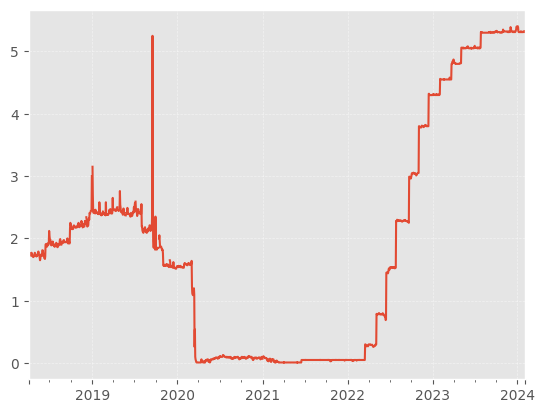

In [ ]:
tables['SOFR'].plot.line()

***
### 2. Filtering/Cleaning Data

We filter the fetched data for the date range of interest in this assignment. We also moved the date to the index for easier manipulation.

**Data Frames:**

`ticker1_df`: (pd.DataFrame) All data for the first ticker symbol listed in `SpreadTicker` class (GDS in this case)

`ticker2_df`: (pd.DataFrame) All data for the second ticker symbol listed in `SpreadTicker` class (RING in this case)

`svol_df`: (pd.DataFrame) All data for the SVOL ticker

`ff3_df`: (pd.DataFrame) All data for the returns of each factor from the Fama-French 3 factor model and the risk-free rates


In [7]:
financial_data_df = Processing.process_financial_data(tables['MKTV'], tables['FR'], tables['FC'], start_date=LOWER_DATE, end_date=UPPER_DATE)
financial_data_df

Filtering data...


Merging tables...
Sorting table...
Grouping and forward filling data...


C:\Users\Alex\AppData\Local\Temp\ipykernel_74140\2970986107.py:410: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  financial_data_df = financial_data_df.groupby('m_ticker').apply(lambda group: expand_ffill(group, 'tradable_date'))
C:\Users\Alex\AppData\Local\Temp\ipykernel_74140\2970986107.py:410: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  financial_data_df = financial_data_df.groupby('m_ticker').apply(lambda group: expand_ffill(group, 'tradable_date'))


m_ticker tradable_date per_end_date per_type  ret_invst  \
0            #AAO    2022-03-01   2021-12-31        Q     1.2221   
1            #AAO    2022-03-02   2021-12-31        Q     1.2221   
2            #AAO    2022-03-03   2021-12-31        Q     1.2221   
3            #AAO    2022-03-04   2021-12-31        Q     1.2221   
4            #AAO    2022-03-05   2021-12-31        Q     1.2221   
...           ...           ...          ...      ...        ...   
10235052     ZUES    2024-06-25   2023-09-30        Q     1.6397   
10235053     ZUES    2024-06-26   2023-09-30        Q     1.6397   
10235054     ZUES    2024-06-27   2023-09-30        Q     1.6397   
10235055     ZUES    2024-06-28   2023-09-30        Q     1.6397   
10235056     ZUES    2024-06-29   2023-09-30        Q     1.6397   

          tot_debt_tot_equity filing_date  net_lterm_debt  tot_lterm_debt  \
0                      0.0858  2022-02-28          6.6140         40.0000   
1                      0.0858  2022-02-28          6.6140         40.0000   
2                      0.0858  2022-02-28          6.6140         40.0000   
3                      0.0858  2022-02-28          6.6140         40.0000   
4                      0.0858  2022-02-28          6.6140         40.0000   
...                       ...         ...             ...             ...   
10235052               0.3578  2023-11-03         -0.7370        196.5270   
10235053               0.3578  2023-11-03         -0.7370        196.5270   
10235054               0.3578  2023-11-03         -0.7370        196.5270   
10235055               0.3578  2023-11-03         -0.7370        196.5270   
10235056               0.3578  2023-11-03         -0.7370        196.5270   

          eps_diluted_net  basic_net_eps    mkt_val  lterm_debt    eps  \
0                  0.0800         0.0800 4,164.3600     40.0000 0.0800   
1                  0.0800         0.0800 4,164.3600     40.0000 0.0800   
2                  0.0800         0.0800 4,164.3600     40.0000 0.0800   
3                  0.0800         0.0800 4,164.3600     40.0000 0.0800   
4                  0.0800         0.0800 4,164.3600     40.0000 0.0800   
...                   ...            ...        ...         ...    ...   
10235052           1.0600         1.0600   625.7600     -0.7370 1.0600   
10235053           1.0600         1.0600   625.7600     -0.7370 1.0600   
10235054           1.0600         1.0600   625.7600     -0.7370 1.0600   
10235055           1.0600         1.0600   625.7600     -0.7370 1.0600   
10235056           1.0600         1.0600   625.7600     -0.7370 1.0600   

             return  
0        5,138.1484  
1        5,138.1484  
2        5,138.1484  
3        5,138.1484  
4        5,138.1484  
...             ...  
10235052 1,024.8502  
10235053 1,024.8502  
10235054 1,024.8502  
10235055 1,024.8502  
10235056 1,024.8502  

[10235057 rows x 15 columns]

In [8]:
temp_copy = financial_data_df.copy()

In [10]:
universe_tickers = financial_data_df['m_ticker'].unique()
universe_tickers

array(['#AAO', '#ACR', '#ALA', ..., 'ZOS', 'ZTS', 'ZUES'], dtype=object)

### Filtering Debt to Market Capitalization

In [11]:
financial_data_df[financial_data_df['tot_debt_tot_equity'] >= 0.5]['m_ticker'].unique().shape

(2807,)

In [12]:
tables['PRICES'] = DataFetching.fetch_quandl_table(
    'QUOTEMEDIA/PRICES', 
    ticker=list(universe_tickers),  
    qopts = { 'columns': ['ticker', 'date', 'adj_close'] },
    date={'gte': LOWER_DATE, 'lte':UPPER_DATE}, 
    avoid_download=False,
    replace_existing=True
    )

Removing old file C:\Users\Alex\Desktop\Academic\UChicago\FINM 33150\quandl_data_table_downloads\QUOTEMEDIA/PRICES_20240201.zip size 27818260
Download finished: 27818260 bytes
Removing old symlink
Creating symlink: C:\Users\Alex\Desktop\Academic\UChicago\FINM 33150\quandl_data_table_downloads\QUOTEMEDIA/PRICES_20240201.zip -> C:\Users\Alex\Desktop\Academic\UChicago\FINM 33150\quandl_data_table_downloads\QUOTEMEDIA/PRICES_latest.zip


### 2390 Trading Days in Range

In [31]:
financial_data_df = temp_copy.copy()
financial_data_df

m_ticker tradable_date per_end_date per_type  ret_invst  \
0            #AAO    2022-03-01   2021-12-31        Q     1.2221   
1            #AAO    2022-03-02   2021-12-31        Q     1.2221   
2            #AAO    2022-03-03   2021-12-31        Q     1.2221   
3            #AAO    2022-03-04   2021-12-31        Q     1.2221   
4            #AAO    2022-03-05   2021-12-31        Q     1.2221   
...           ...           ...          ...      ...        ...   
10235052     ZUES    2024-06-25   2023-09-30        Q     1.6397   
10235053     ZUES    2024-06-26   2023-09-30        Q     1.6397   
10235054     ZUES    2024-06-27   2023-09-30        Q     1.6397   
10235055     ZUES    2024-06-28   2023-09-30        Q     1.6397   
10235056     ZUES    2024-06-29   2023-09-30        Q     1.6397   

          tot_debt_tot_equity filing_date  net_lterm_debt  tot_lterm_debt  \
0                      0.0858  2022-02-28          6.6140         40.0000   
1                      0.0858  2022-02-28          6.6140         40.0000   
2                      0.0858  2022-02-28          6.6140         40.0000   
3                      0.0858  2022-02-28          6.6140         40.0000   
4                      0.0858  2022-02-28          6.6140         40.0000   
...                       ...         ...             ...             ...   
10235052               0.3578  2023-11-03         -0.7370        196.5270   
10235053               0.3578  2023-11-03         -0.7370        196.5270   
10235054               0.3578  2023-11-03         -0.7370        196.5270   
10235055               0.3578  2023-11-03         -0.7370        196.5270   
10235056               0.3578  2023-11-03         -0.7370        196.5270   

          eps_diluted_net  basic_net_eps    mkt_val  lterm_debt    eps  \
0                  0.0800         0.0800 4,164.3600     40.0000 0.0800   
1                  0.0800         0.0800 4,164.3600     40.0000 0.0800   
2                  0.0800         0.0800 4,164.3600     40.0000 0.0800   
3                  0.0800         0.0800 4,164.3600     40.0000 0.0800   
4                  0.0800         0.0800 4,164.3600     40.0000 0.0800   
...                   ...            ...        ...         ...    ...   
10235052           1.0600         1.0600   625.7600     -0.7370 1.0600   
10235053           1.0600         1.0600   625.7600     -0.7370 1.0600   
10235054           1.0600         1.0600   625.7600     -0.7370 1.0600   
10235055           1.0600         1.0600   625.7600     -0.7370 1.0600   
10235056           1.0600         1.0600   625.7600     -0.7370 1.0600   

             return  
0        5,138.1484  
1        5,138.1484  
2        5,138.1484  
3        5,138.1484  
4        5,138.1484  
...             ...  
10235052 1,024.8502  
10235053 1,024.8502  
10235054 1,024.8502  
10235055 1,024.8502  
10235056 1,024.8502  

[10235057 rows x 15 columns]

In [32]:
prices_table = tables['PRICES']
prices_table

ticker        date  adj_close
0           AA  2016-11-01    22.5215
1           AA  2016-11-02    22.4334
2           AA  2016-11-03    23.6476
3           AA  2016-11-04    24.6757
4           AA  2016-11-07    24.5582
...        ...         ...        ...
3640331    ZTS  2024-01-25   187.3200
3640332    ZTS  2024-01-26   191.5200
3640333    ZTS  2024-01-29   192.7600
3640334    ZTS  2024-01-30   191.4300
3640335    ZTS  2024-01-31   187.8100

[3640336 rows x 3 columns]

In [33]:
prices_table['ticker'].value_counts().max()

2537

In [34]:
universe_tickers = (prices_table['ticker'].value_counts() == prices_table['ticker'].value_counts().max()).sort_index()
universe_tickers = universe_tickers.index[universe_tickers].tolist()
universe_tickers

['AAL',
 'AAMC',
 'AAOI',
 'AAPL',
 'ABBV',
 'ABCB',
 'ABR',
 'ABT',
 'ACHC',
 'ACIC',
 'ACLS',
 'ACM',
 'ACNB',
 'ACOR',
 'ACP',
 'ACRE',
 'ADC',
 'ADM',
 'ADMA',
 'ADTN',
 'AE',
 'AEIS',
 'AEL',
 'AEP',
 'AER',
 'AGCO',
 'AGEN',
 'AGIO',
 'AGRO',
 'AHH',
 'AIRI',
 'AIV',
 'AIZ',
 'AKAM',
 'ALB',
 'ALCO',
 'ALEX',
 'ALIM',
 'ALK',
 'ALKS',
 'ALNY',
 'ALSN',
 'ALV',
 'AMBC',
 'AMCX',
 'AME',
 'AMG',
 'AMGN',
 'AMH',
 'AMKR',
 'AMNB',
 'AMSC',
 'AMZN',
 'ANDE',
 'ANGI',
 'ANIK',
 'ANSS',
 'AOSL',
 'AP',
 'APA',
 'APAM',
 'APD',
 'APDN',
 'APEI',
 'APH',
 'APO',
 'APT',
 'ARLP',
 'ARMK',
 'AROW',
 'ARW',
 'ASGN',
 'ASH',
 'ASPS',
 'ASTE',
 'ASYS',
 'ATLO',
 'ATNI',
 'ATNM',
 'ATR',
 'ATRO',
 'AUDC',
 'AVT',
 'AVY',
 'AWI',
 'AXL',
 'AXON',
 'AXP',
 'AXS',
 'AXTI',
 'AZPN',
 'BA',
 'BAH',
 'BALL',
 'BANF',
 'BBGI',
 'BBSI',
 'BC',
 'BCBP',
 'BCOV',
 'BCRX',
 'BDX',
 'BERY',
 'BFAM',
 'BFIN',
 'BFS',
 'BG',
 'BGFV',
 'BGH',
 'BGS',
 'BK',
 'BKCC',
 'BKD',
 'BKU',
 'BLDR',
 'BLK',
 'BLKB',


In [35]:
prices_table = prices_table[prices_table['ticker'].isin(universe_tickers)]
prices_table['date'] = pd.to_datetime(prices_table['date'])
prices_table = Processing.expand_ffill_multi_index(prices_table, 'date', ['ticker']).reset_index()
prices_table = Processing.groupby_ticker_returns(prices_table, 'date', ['ticker'], 'adj_close').reset_index()
prices_table

C:\Users\Alex\AppData\Local\Temp\ipykernel_74140\1492768689.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_table['date'] = pd.to_datetime(prices_table['date'])
C:\Users\Alex\AppData\Local\Temp\ipykernel_74140\2970986107.py:429: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  time_series = time_series.groupby(groupby_column_names).apply(lambda group: expand_ffill(group, date_column_name))
C:\Users\Alex\AppData\Local\Temp\ipykernel_74140\2970986107.

ticker       date  adj_close  asset_returns
0          AAL 2014-01-02    23.9041         0.0000
1          AAL 2014-01-03    25.0164         0.0465
2          AAL 2014-01-04    25.0164         0.0000
3          AAL 2014-01-05    25.0164         0.0000
4          AAL 2014-01-06    25.4783         0.0185
...        ...        ...        ...            ...
3107603    ZTS 2024-01-27   191.5200         0.0000
3107604    ZTS 2024-01-28   191.5200         0.0000
3107605    ZTS 2024-01-29   192.7600         0.0065
3107606    ZTS 2024-01-30   191.4300        -0.0069
3107607    ZTS 2024-01-31   187.8100        -0.0189

[3107608 rows x 4 columns]

In [36]:
financial_data_df = financial_data_df[financial_data_df['m_ticker'].isin(universe_tickers)]
financial_data_df

m_ticker tradable_date per_end_date per_type  ret_invst  \
179610        AAL    2014-04-25   2014-03-31        Q     2.9378   
179611        AAL    2014-04-26   2014-03-31        Q     2.9378   
179612        AAL    2014-04-27   2014-03-31        Q     2.9378   
179613        AAL    2014-04-28   2014-03-31        Q     2.9378   
179614        AAL    2014-04-29   2014-03-31        Q     2.9378   
...           ...           ...          ...      ...        ...   
10231339      ZTS    2024-06-25   2023-09-30        Q     5.1264   
10231340      ZTS    2024-06-26   2023-09-30        Q     5.1264   
10231341      ZTS    2024-06-27   2023-09-30        Q     5.1264   
10231342      ZTS    2024-06-28   2023-09-30        Q     5.1264   
10231343      ZTS    2024-06-29   2023-09-30        Q     5.1264   

          tot_debt_tot_equity filing_date  net_lterm_debt  tot_lterm_debt  \
179610                15.2374  2014-04-24       -277.0000     15,244.0000   
179611                15.2374  2014-04-24       -277.0000     15,244.0000   
179612                15.2374  2014-04-24       -277.0000     15,244.0000   
179613                15.2374  2014-04-24       -277.0000     15,244.0000   
179614                15.2374  2014-04-24       -277.0000     15,244.0000   
...                       ...         ...             ...             ...   
10231339               1.2917  2023-11-02     -1,350.0000      6,552.0000   
10231340               1.2917  2023-11-02     -1,350.0000      6,552.0000   
10231341               1.2917  2023-11-02     -1,350.0000      6,552.0000   
10231342               1.2917  2023-11-02     -1,350.0000      6,552.0000   
10231343               1.2917  2023-11-02     -1,350.0000      6,552.0000   

          eps_diluted_net  basic_net_eps     mkt_val  lterm_debt    eps  \
179610             0.6500         0.6600 23,788.2800   -277.0000 0.6500   
179611             0.6500         0.6600 23,788.2800   -277.0000 0.6500   
179612             0.6500         0.6600 23,788.2800   -277.0000 0.6500   
179613             0.6500         0.6600 23,788.2800   -277.0000 0.6500   
179614             0.6500         0.6600 23,788.2800   -277.0000 0.6500   
...                   ...            ...         ...         ...    ...   
10231339           1.2900         1.2900 79,876.6000 -1,350.0000 1.2900   
10231340           1.2900         1.2900 79,876.6000 -1,350.0000 1.2900   
10231341           1.2900         1.2900 79,876.6000 -1,350.0000 1.2900   
10231342           1.2900         1.2900 79,876.6000 -1,350.0000 1.2900   
10231343           1.2900         1.2900 79,876.6000 -1,350.0000 1.2900   

               return  
179610    69,071.4384  
179611    69,071.4384  
179612    69,071.4384  
179613    69,071.4384  
179614    69,071.4384  
...               ...  
10231339 402,558.7622  
10231340 402,558.7622  
10231341 402,558.7622  
10231342 402,558.7622  
10231343 402,558.7622  

[2870895 rows x 15 columns]

In [37]:
financial_data_df = financial_data_df.merge(
    prices_table, 
    left_on=['tradable_date', 'm_ticker'], right_on=['date', 'ticker'], 
    how='left'
)
financial_data_df = financial_data_df.merge(
    prices_table, 
    left_on=['per_end_date', 'm_ticker'], right_on=['date', 'ticker'], 
    how='left', suffixes=('', '_ped')
)

In [52]:
financial_data_df = financial_data_df.drop(columns=['ticker', 'date', 'date_ped', 'ticker_ped', 'asset_returns_ped'])
financial_data_df

m_ticker tradable_date per_end_date per_type  ret_invst  \
0            AAL    2014-04-25   2014-03-31        Q     2.9378   
1            AAL    2014-04-26   2014-03-31        Q     2.9378   
2            AAL    2014-04-27   2014-03-31        Q     2.9378   
3            AAL    2014-04-28   2014-03-31        Q     2.9378   
4            AAL    2014-04-29   2014-03-31        Q     2.9378   
...          ...           ...          ...      ...        ...   
2870890      ZTS    2024-06-25   2023-09-30        Q     5.1264   
2870891      ZTS    2024-06-26   2023-09-30        Q     5.1264   
2870892      ZTS    2024-06-27   2023-09-30        Q     5.1264   
2870893      ZTS    2024-06-28   2023-09-30        Q     5.1264   
2870894      ZTS    2024-06-29   2023-09-30        Q     5.1264   

         tot_debt_tot_equity filing_date  net_lterm_debt  tot_lterm_debt  \
0                    15.2374  2014-04-24       -277.0000     15,244.0000   
1                    15.2374  2014-04-24       -277.0000     15,244.0000   
2                    15.2374  2014-04-24       -277.0000     15,244.0000   
3                    15.2374  2014-04-24       -277.0000     15,244.0000   
4                    15.2374  2014-04-24       -277.0000     15,244.0000   
...                      ...         ...             ...             ...   
2870890               1.2917  2023-11-02     -1,350.0000      6,552.0000   
2870891               1.2917  2023-11-02     -1,350.0000      6,552.0000   
2870892               1.2917  2023-11-02     -1,350.0000      6,552.0000   
2870893               1.2917  2023-11-02     -1,350.0000      6,552.0000   
2870894               1.2917  2023-11-02     -1,350.0000      6,552.0000   

         eps_diluted_net  ...     mkt_val  lterm_debt    eps       return  \
0                 0.6500  ... 23,788.2800   -277.0000 0.6500  69,071.4384   
1                 0.6500  ... 23,788.2800   -277.0000 0.6500  69,071.4384   
2                 0.6500  ... 23,788.2800   -277.0000 0.6500  69,071.4384   
3                 0.6500  ... 23,788.2800   -277.0000 0.6500  69,071.4384   
4                 0.6500  ... 23,788.2800   -277.0000 0.6500  69,071.4384   
...                  ...  ...         ...         ...    ...          ...   
2870890           1.2900  ... 79,876.6000 -1,350.0000 1.2900 402,558.7622   
2870891           1.2900  ... 79,876.6000 -1,350.0000 1.2900 402,558.7622   
2870892           1.2900  ... 79,876.6000 -1,350.0000 1.2900 402,558.7622   
2870893           1.2900  ... 79,876.6000 -1,350.0000 1.2900 402,558.7622   
2870894           1.2900  ... 79,876.6000 -1,350.0000 1.2900 402,558.7622   

         adj_close  asset_returns  adj_close_ped      pe  debt_to_mkt_val  \
0          33.9333        -0.0338        34.4989 52.2051          15.4914   
1          33.9333         0.0000        34.4989 52.2051          15.4914   
2          33.9333         0.0000        34.4989 52.2051          15.4914   
3          33.1415        -0.0233        34.4989 50.9870          15.8615   
4          33.4714         0.0100        34.4989 51.4945          15.7051   
...            ...            ...            ...     ...              ...   
2870890        NaN            NaN       173.1727     NaN              NaN   
2870891        NaN            NaN       173.1727     NaN              NaN   
2870892        NaN            NaN       173.1727     NaN              NaN   
2870893        NaN            NaN       173.1727     NaN              NaN   
2870894        NaN            NaN       173.1727     NaN              NaN   

         adj_ret_invst  
0               2.9873  
1               2.9873  
2               2.9873  
3               3.0596  
4               3.0291  
...                ...  
2870890            NaN  
2870891            NaN  
2870892            NaN  
2870893            NaN  
2870894            NaN  

[2870895 rows x 21 columns]

In [40]:
financial_data_df['pe'] = financial_data_df['adj_close'] / financial_data_df['eps']

In [41]:
financial_data_df['debt_to_mkt_val'] = financial_data_df['tot_debt_tot_equity'] * (financial_data_df['adj_close_ped'] / financial_data_df['adj_close'])

In [42]:
financial_data_df['adj_ret_invst'] = financial_data_df['return'] / (financial_data_df['mkt_val'] * (financial_data_df['adj_close'] / financial_data_df['adj_close_ped']) + financial_data_df['lterm_debt'])

In [44]:
universe_tickers = financial_data_df['m_ticker'].unique()
universe_tickers

array(['AAL', 'AAMC', 'AAOI', 'AAPL', 'ABBV', 'ABCB', 'ABR', 'ABT',
       'ACHC', 'ACIC', 'ACLS', 'ACM', 'ACNB', 'ACOR', 'ACP', 'ACRE',
       'ADC', 'ADM', 'ADMA', 'ADTN', 'AE', 'AEIS', 'AEL', 'AEP', 'AER',
       'AGCO', 'AGEN', 'AGIO', 'AGRO', 'AHH', 'AIRI', 'AIV', 'AIZ',
       'AKAM', 'ALB', 'ALCO', 'ALEX', 'ALIM', 'ALK', 'ALKS', 'ALNY',
       'ALSN', 'ALV', 'AMBC', 'AMCX', 'AME', 'AMG', 'AMGN', 'AMH', 'AMKR',
       'AMNB', 'AMSC', 'AMZN', 'ANDE', 'ANGI', 'ANIK', 'ANSS', 'AOSL',
       'AP', 'APA', 'APAM', 'APD', 'APDN', 'APEI', 'APH', 'APO', 'APT',
       'ARLP', 'ARMK', 'AROW', 'ARW', 'ASGN', 'ASH', 'ASPS', 'ASTE',
       'ASYS', 'ATLO', 'ATNI', 'ATNM', 'ATR', 'ATRO', 'AUDC', 'AVT',
       'AVY', 'AWI', 'AXL', 'AXON', 'AXP', 'AXS', 'AXTI', 'AZPN', 'BA',
       'BAH', 'BALL', 'BANF', 'BBGI', 'BBSI', 'BC', 'BCBP', 'BCOV',
       'BCRX', 'BDX', 'BERY', 'BFAM', 'BFIN', 'BFS', 'BG', 'BGFV', 'BGH',
       'BGS', 'BK', 'BKCC', 'BKD', 'BKU', 'BLDR', 'BLK', 'BLKB', 'BLMN',
       'BLX

In [45]:
unwanted_sectors = {
    'automotive': [5],
    'financial': [13],
    'insurance': []
}
ticker_filter = tables['FC'][(~tables['FC']['zacks_sector_code'].isin([v for v in unwanted_sectors.values()]))]['m_ticker'].unique()
print(len(ticker_filter))

16380


In [46]:
financial_data_df = financial_data_df[financial_data_df['m_ticker'].isin(ticker_filter)]
display(financial_data_df['m_ticker'].unique().shape)

(844,)

***
### 3. Configuration

Here we set up a couple metrics for controlling position size of trades and initial capital to simulate portfolio returns and volatility.

**Variables:**

`lower_volume_ticker`: (str) the symbol of the ticker with lower dollar volumne traded for this time period for the spread

`higher_volume_ticker`: (str) the symbol of the ticker with higher dollar volumne traded for this time period for the spread

`initial_capital`: (float) max median of the 15 day trailing dollar volume of the less liquid stock in the pair

### 4. Validation

In [53]:
validation_data = {
    'Debt To Mkt Cap': [2.266511, 1.958932, 1.790877, 1.820469, 2.067135, 2.087139, 1.771630, 1.733494, 1.736698, 1.725479,
                        1.535812, 1.533542, 1.628426, 2.089332, 1.940811, 1.951675, 1.779911, 1.423720, 1.377587, 1.380796,
                        1.526555, 1.677865, 1.600181, 1.566785, 1.407799, 1.450422, 1.221106, 1.241113, 1.097919, 1.504358],
    
    'Return On Inv': [5.972855, 4.313252, 3.943927, 4.008969, 4.550975, 7.970179, 6.767552, 6.622135, 6.634354, 7.645313,
                      6.802995, 6.792915, 7.214236, 4.390834, 4.077122, 4.100062, 3.737540, 5.437435, 5.260454, 5.272760,
                      5.832136, 8.460450, 8.066864, 7.897718, 7.092939, 3.872644, 3.265751, 3.318780, 2.938902, 5.366827],
    
    'Price To Earnings': [159.232948, 202.232157, 221.209527, 217.613731, 191.646411, 126.855597, 149.447249, 152.735015,
                          152.453207, 135.281225, 151.987938, 152.212945, 143.343896, 282.497026, 304.115168, 302.422243,
                          331.606389, 217.724877, 225.016059, 224.493252, 203.058101, 152.048436, 159.429879, 162.828128,
                          181.216741, 263.944889, 313.511980, 308.458138, 348.688320, 268.798647]
}

# Dates as the index
validation_index = pd.to_datetime([
    '2021-10-27', '2021-10-28', '2021-12-31', '2022-01-03', '2022-02-23', '2022-02-24', '2022-03-31', '2022-04-01',
    '2022-04-29', '2022-05-02', '2022-06-30', '2022-07-01', '2022-08-04', '2022-08-05', '2022-09-30', '2022-10-03',
    '2022-11-01', '2022-11-02', '2022-12-30', '2023-01-03', '2023-02-22', '2023-02-23', '2023-03-31', '2023-04-03',
    '2023-04-27', '2023-04-28', '2023-06-30', '2023-07-03', '2023-08-08', '2023-08-09'
])

# Create DataFrame
ratio_validation_df = pd.DataFrame(validation_data, index=validation_index)
ratio_validation_df.index.name = 'trade_date'

# Display the resulting DataFrame
display(ratio_validation_df)


Debt To Mkt Cap  Return On Inv  Price To Earnings
trade_date                                                   
2021-10-27           2.2665         5.9729           159.2329
2021-10-28           1.9589         4.3133           202.2322
2021-12-31           1.7909         3.9439           221.2095
2022-01-03           1.8205         4.0090           217.6137
2022-02-23           2.0671         4.5510           191.6464
2022-02-24           2.0871         7.9702           126.8556
2022-03-31           1.7716         6.7676           149.4472
2022-04-01           1.7335         6.6221           152.7350
2022-04-29           1.7367         6.6344           152.4532
2022-05-02           1.7255         7.6453           135.2812
2022-06-30           1.5358         6.8030           151.9879
2022-07-01           1.5335         6.7929           152.2129
2022-08-04           1.6284         7.2142           143.3439
2022-08-05           2.0893         4.3908           282.4970
2022-09-30           1.9408         4.0771           304.1152
2022-10-03           1.9517         4.1001           302.4222
2022-11-01           1.7799         3.7375           331.6064
2022-11-02           1.4237         5.4374           217.7249
2022-12-30           1.3776         5.2605           225.0161
2023-01-03           1.3808         5.2728           224.4933
2023-02-22           1.5266         5.8321           203.0581
2023-02-23           1.6779         8.4604           152.0484
2023-03-31           1.6002         8.0669           159.4299
2023-04-03           1.5668         7.8977           162.8281
2023-04-27           1.4078         7.0929           181.2167
2023-04-28           1.4504         3.8726           263.9449
2023-06-30           1.2211         3.2658           313.5120
2023-07-03           1.2411         3.3188           308.4581
2023-08-08           1.0979         2.9389           348.6883
2023-08-09           1.5044         5.3668           268.7986

In [54]:
test_df = ratio_validation_df.merge(
    # PE RATIO
    financial_data_df[financial_data_df['m_ticker'] == 'LLY'][['tradable_date', 'pe']].set_index('tradable_date'),
    how='left',
    left_index=True, right_index=True
).merge(
    # lly_debt_mktval_df[['d_mv']],
    financial_data_df[financial_data_df['m_ticker'] == 'LLY'][['tradable_date', 'debt_to_mkt_val']].set_index('tradable_date'),
    how='left',
    left_index=True, right_index=True
).merge(
    #lly_roi_df[['adj_ret_invst']],
    financial_data_df[financial_data_df['m_ticker'] == 'LLY'][['tradable_date', 'adj_ret_invst']].set_index('tradable_date'),
    how='left',
    left_index=True, right_index=True
)
test_df = test_df[['Debt To Mkt Cap', 'debt_to_mkt_val', 'Return On Inv', 'adj_ret_invst', 'Price To Earnings', 'pe']]
display(test_df)
assert np.allclose(test_df['debt_to_mkt_val'], test_df['Debt To Mkt Cap'])
assert np.allclose(test_df['adj_ret_invst'], test_df['Return On Inv'])
assert np.allclose(test_df['pe'], test_df['Price To Earnings'])

Debt To Mkt Cap  debt_to_mkt_val  Return On Inv  adj_ret_invst  \
trade_date                                                                   
2021-10-27           2.2665           2.2665         5.9729         5.9729   
2021-10-28           1.9589           1.9589         4.3133         4.3133   
2021-12-31           1.7909           1.7909         3.9439         3.9439   
2022-01-03           1.8205           1.8205         4.0090         4.0090   
2022-02-23           2.0671           2.0671         4.5510         4.5510   
2022-02-24           2.0871           2.0871         7.9702         7.9702   
2022-03-31           1.7716           1.7716         6.7676         6.7676   
2022-04-01           1.7335           1.7335         6.6221         6.6221   
2022-04-29           1.7367           1.7367         6.6344         6.6344   
2022-05-02           1.7255           1.7255         7.6453         7.6453   
2022-06-30           1.5358           1.5358         6.8030         6.8030   
2022-07-01           1.5335           1.5335         6.7929         6.7929   
2022-08-04           1.6284           1.6284         7.2142         7.2142   
2022-08-05           2.0893           2.0893         4.3908         4.3908   
2022-09-30           1.9408           1.9408         4.0771         4.0771   
2022-10-03           1.9517           1.9517         4.1001         4.1001   
2022-11-01           1.7799           1.7799         3.7375         3.7375   
2022-11-02           1.4237           1.4237         5.4374         5.4374   
2022-12-30           1.3776           1.3776         5.2605         5.2605   
2023-01-03           1.3808           1.3808         5.2728         5.2728   
2023-02-22           1.5266           1.5266         5.8321         5.8321   
2023-02-23           1.6779           1.6779         8.4604         8.4605   
2023-03-31           1.6002           1.6002         8.0669         8.0669   
2023-04-03           1.5668           1.5668         7.8977         7.8977   
2023-04-27           1.4078           1.4078         7.0929         7.0929   
2023-04-28           1.4504           1.4504         3.8726         3.8726   
2023-06-30           1.2211           1.2211         3.2658         3.2658   
2023-07-03           1.2411           1.2411         3.3188         3.3188   
2023-08-08           1.0979           1.0979         2.9389         2.9389   
2023-08-09           1.5044           1.5044         5.3668         5.3668   

            Price To Earnings       pe  
trade_date                              
2021-10-27           159.2329 159.2329  
2021-10-28           202.2322 202.2322  
2021-12-31           221.2095 221.2095  
2022-01-03           217.6137 217.6137  
2022-02-23           191.6464 191.6464  
2022-02-24           126.8556 126.8556  
2022-03-31           149.4472 149.4472  
2022-04-01           152.7350 152.7350  
2022-04-29           152.4532 152.4532  
2022-05-02           135.2812 135.2812  
2022-06-30           151.9879 151.9879  
2022-07-01           152.2129 152.2129  
2022-08-04           143.3439 143.3439  
2022-08-05           282.4970 282.4970  
2022-09-30           304.1152 304.1152  
2022-10-03           302.4222 302.4222  
2022-11-01           331.6064 331.6064  
2022-11-02           217.7249 217.7249  
2022-12-30           225.0161 225.0161  
2023-01-03           224.4933 224.4933  
2023-02-22           203.0581 203.0581  
2023-02-23           152.0484 152.0484  
2023-03-31           159.4299 159.4299  
2023-04-03           162.8281 162.8281  
2023-04-27           181.2167 181.2167  
2023-04-28           263.9449 263.9449  
2023-06-30           313.5120 313.5120  
2023-07-03           308.4581 308.4581  
2023-08-08           348.6883 348.6883  
2023-08-09           268.7986 268.7986

## III. Exploration: The Universe of Stocks

### 1. Equal Weighted Portfolio Benchmark
---

#### **A. Price Dynamics**

Below we will explore the price dynamics over this time period.

In [74]:
START_DATE = '2016-01-01'
END_DATE = '2023-06-30'
financial_data_df = financial_data_df[(financial_data_df['tradable_date'] >= START_DATE) & (financial_data_df['tradable_date'] <= END_DATE)]
financial_data_df[(financial_data_df['tradable_date'] == START_DATE)]['asset_returns'] = 0

C:\Users\Alex\AppData\Local\Temp\ipykernel_74140\4198259398.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  financial_data_df[(financial_data_df['tradable_date'] == START_DATE)]['asset_returns'] = 0


In [157]:
financial_data_df = Processing.groupby_ticker_moving_mkt_val(financial_data_df, 'tradable_date', 'mkt_val', 'asset_returns', ['m_ticker'])

C:\Users\Alex\AppData\Local\Temp\ipykernel_74140\1772006204.py:452: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  time_series = time_series.groupby(groupby_column_names).apply(lambda group: calc_moving_mkt_val(group, date_column_name, mkt_val_column_name, returns_column_name))



### **Benchmark: Equally Weighted, Daily Rebalanced Portfolio of our Universe** 
***
Note that this portfolio is unrealistic due to trading costs that are not reflected here. 
The equally weighted portfolio performs well over this period of time and closely resembles the S&P 500.


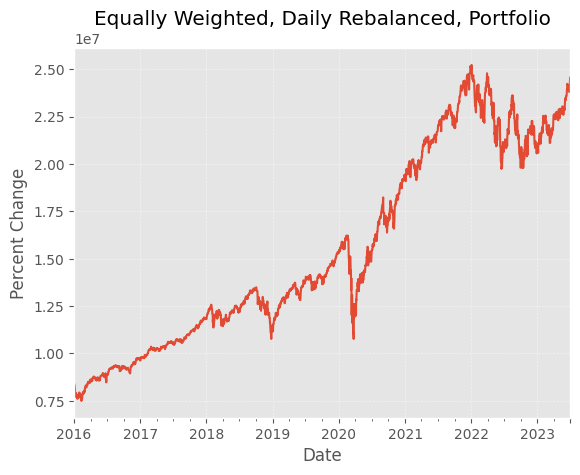

In [164]:
financial_data_df: pd.DataFrame
market_cap_weighted_portfolio = financial_data_df.groupby('tradable_date')[['moving_mkt_val']].sum()
market_cap_weighted_portfolio['returns'] = market_cap_weighted_portfolio.pct_change()

display(Markdown("""
### **Benchmark: Equally Weighted, Daily Rebalanced Portfolio of our Universe** \n***\nNote that this portfolio is unrealistic due to trading costs that are not reflected here. 
The equally weighted portfolio performs well over this period of time and closely resembles the S&P 500.
"""))

# (equally_weighted_rebalanced_portfolio + 1).cumprod().plot.line()
market_cap_weighted_portfolio['moving_mkt_val'].plot.line()
plt.ylabel("Percent Change")
plt.xlabel("Date")
plt.title("Equally Weighted, Daily Rebalanced, Portfolio")
plt.show()


### **Performance: Lowest Decile PE Portfolio** 
***



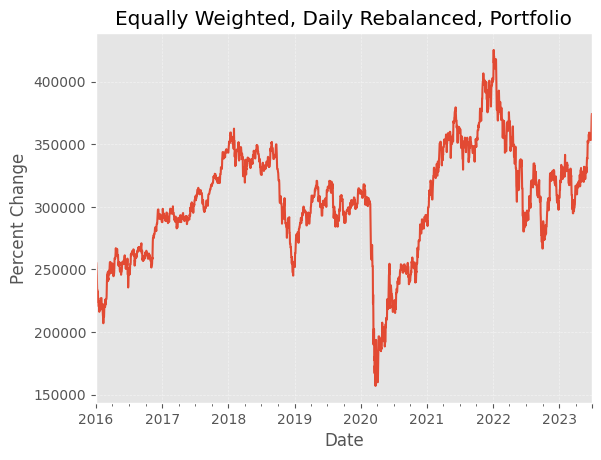

In [165]:
display(Markdown("""
### **Performance: Lowest Decile PE Portfolio** \n***\n
"""))

fd_freeze_df = financial_data_df[financial_data_df['tradable_date'] == '2016-01-01'].sort_values('pe')
fd_freeze_df = fd_freeze_df.head(fd_freeze_df.shape[0] // 20)
fd_freeze_tickers = fd_freeze_df['m_ticker']
bot_decile_pe_portfolio = financial_data_df[financial_data_df['m_ticker'].isin(fd_freeze_tickers)].groupby('tradable_date')[['moving_mkt_val']].sum()
bot_decile_pe_portfolio['returns'] = bot_decile_pe_portfolio['moving_mkt_val'].pct_change()

bot_decile_pe_portfolio['moving_mkt_val'].plot.line()
plt.ylabel("Percent Change")
plt.xlabel("Date")
plt.title("Equally Weighted, Daily Rebalanced, Portfolio")
plt.show()


### **Performance: Highest Decile PE Portfolio** 
***



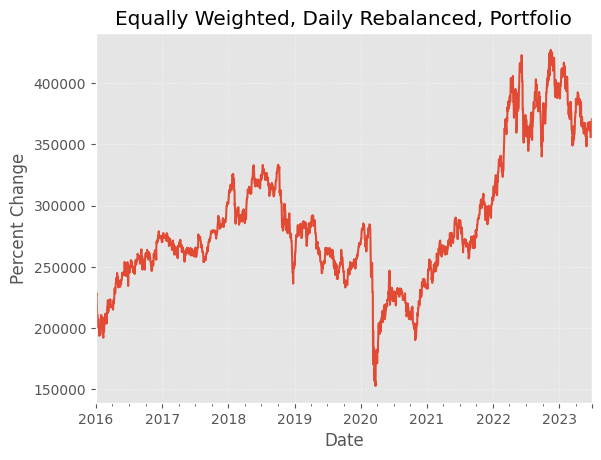

In [166]:
display(Markdown("""
### **Performance: Highest Decile PE Portfolio** \n***\n
"""))

fd_freeze_df = financial_data_df[financial_data_df['tradable_date'] == '2016-01-01'].sort_values('pe')
fd_freeze_df = fd_freeze_df.tail(fd_freeze_df.shape[0] // 20)
fd_freeze_tickers = fd_freeze_df['m_ticker']
top_decile_pe_portfolio = financial_data_df[financial_data_df['m_ticker'].isin(fd_freeze_tickers)].groupby('tradable_date')[['moving_mkt_val']].sum()
top_decile_pe_portfolio['returns'] = top_decile_pe_portfolio['moving_mkt_val'].pct_change()

top_decile_pe_portfolio['moving_mkt_val'].plot.line()
plt.ylabel("Percent Change")
plt.xlabel("Date")
plt.title("Equally Weighted, Daily Rebalanced, Portfolio")
plt.show()


### **Performance: Lowest Decile Debt to Market Value Portfolio** 
***



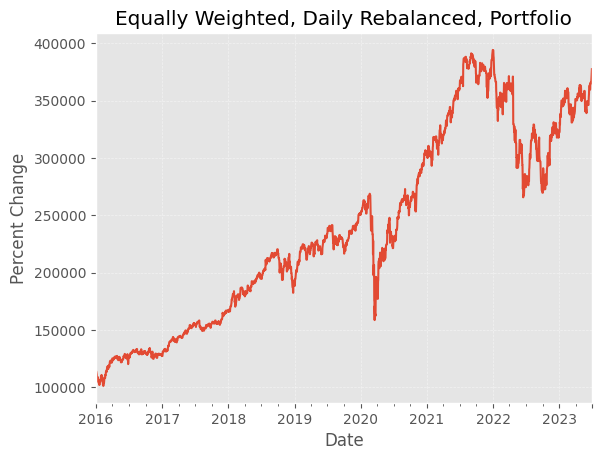

In [167]:
display(Markdown("""
### **Performance: Lowest Decile Debt to Market Value Portfolio** \n***\n
"""))

fd_freeze_df = financial_data_df[financial_data_df['tradable_date'] == '2016-01-01'].sort_values('debt_to_mkt_val')
fd_freeze_df = fd_freeze_df.head(fd_freeze_df.shape[0] // 20)
fd_freeze_tickers = fd_freeze_df['m_ticker']
bot_decile_debt_mktval_portfolio = financial_data_df[financial_data_df['m_ticker'].isin(fd_freeze_tickers)].groupby('tradable_date')[['moving_mkt_val']].sum()
bot_decile_debt_mktval_portfolio['returns'] = bot_decile_debt_mktval_portfolio['moving_mkt_val'].pct_change()

bot_decile_debt_mktval_portfolio['moving_mkt_val'].plot.line()
plt.ylabel("Percent Change")
plt.xlabel("Date")
plt.title("Equally Weighted, Daily Rebalanced, Portfolio")
plt.show()


### **Performance: Highest Decile Debt to Market Value Portfolio** 
***



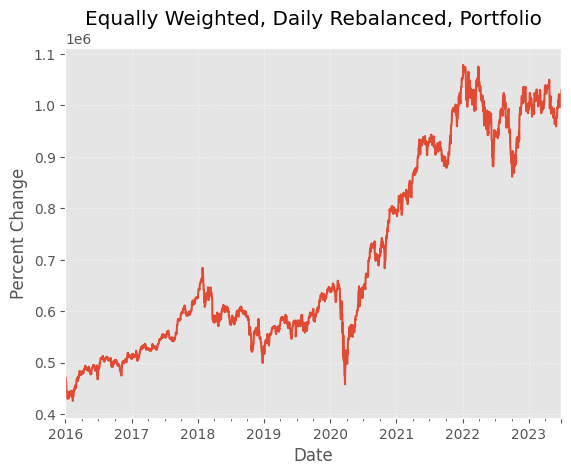

In [187]:
display(Markdown("""
### **Performance: Highest Decile Debt to Market Value Portfolio** \n***\n
"""))

fd_freeze_df = financial_data_df[financial_data_df['tradable_date'] == '2016-01-01'].sort_values('debt_to_mkt_val')
fd_freeze_df = fd_freeze_df.tail(fd_freeze_df.shape[0] // 20)
fd_freeze_tickers = fd_freeze_df['m_ticker']
top_decile_debt_mktval_portfolio = financial_data_df[financial_data_df['m_ticker'].isin(fd_freeze_tickers)].groupby('tradable_date')[['moving_mkt_val']].sum()
top_decile_debt_mktval_portfolio['returns'] = top_decile_debt_mktval_portfolio['moving_mkt_val'].pct_change()

top_decile_debt_mktval_portfolio['moving_mkt_val'].plot.line()
plt.ylabel("Percent Change")
plt.xlabel("Date")
plt.title("Equally Weighted, Daily Rebalanced, Portfolio")
plt.show()


### **Performance: Lowest Decile Return on Investment Portfolio** 
***



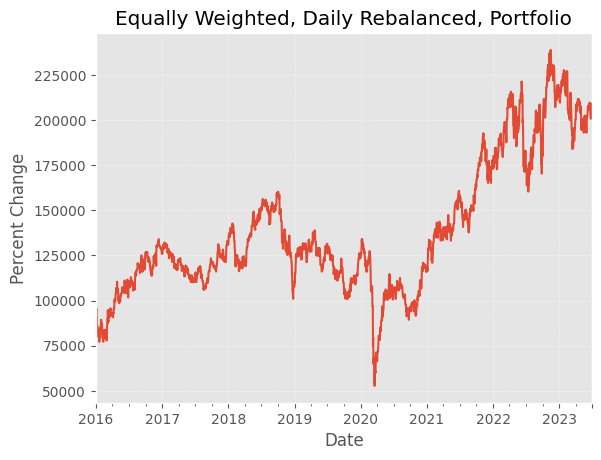

In [203]:
display(Markdown("""
### **Performance: Lowest Decile Return on Investment Portfolio** \n***\n
"""))

fd_freeze_df = financial_data_df[financial_data_df['tradable_date'] == '2016-01-01'].sort_values('adj_ret_invst')
fd_freeze_df = fd_freeze_df.head(fd_freeze_df.shape[0] // 20)
fd_freeze_tickers = fd_freeze_df['m_ticker']
bot_decile_ret_invst_portfolio = financial_data_df[financial_data_df['m_ticker'].isin(fd_freeze_tickers)].groupby('tradable_date')[['moving_mkt_val']].sum()
bot_decile_ret_invst_portfolio['returns'] = bot_decile_ret_invst_portfolio['moving_mkt_val'].pct_change()

bot_decile_ret_invst_portfolio['moving_mkt_val'].plot.line()
plt.ylabel("Percent Change")
plt.xlabel("Date")
plt.title("Equally Weighted, Daily Rebalanced, Portfolio")
plt.show()


### **Performance: Lowest Decile Adjusted Return on Investment Portfolio** 
***



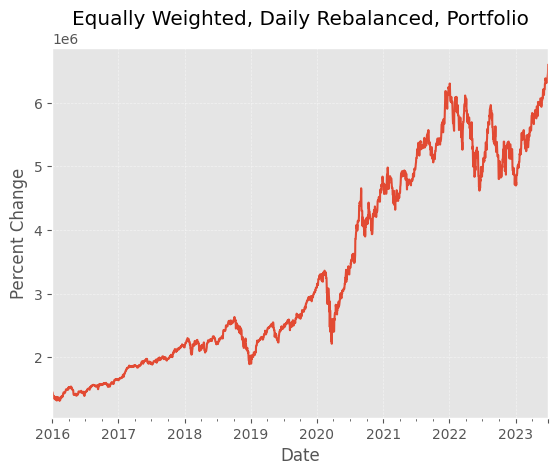

In [208]:
display(Markdown("""
### **Performance: Lowest Decile Adjusted Return on Investment Portfolio** \n***\n
"""))

fd_freeze_df = financial_data_df[financial_data_df['tradable_date'] == '2016-01-01'].sort_values('adj_ret_invst')
fd_freeze_df = fd_freeze_df.tail(fd_freeze_df.shape[0] // 20)
fd_freeze_tickers = fd_freeze_df['m_ticker']
top_decile_ret_invst_portfolio = financial_data_df[financial_data_df['m_ticker'].isin(fd_freeze_tickers)].groupby('tradable_date')[['moving_mkt_val']].sum()
top_decile_ret_invst_portfolio['returns'] = top_decile_ret_invst_portfolio['moving_mkt_val'].pct_change()

top_decile_ret_invst_portfolio['moving_mkt_val'].plot.line()
plt.ylabel("Percent Change")
plt.xlabel("Date")
plt.title("Equally Weighted, Daily Rebalanced, Portfolio")
plt.show()

#### **B. Returns Dynamics** 

To get a better understanding of the return dynamics, below are a couple charts of the price of each component in our spread over our time horizon.

In [113]:
top_decile_pe_portfolio: pd.Series
top_decile_debt_mktval_portfolio: pd.Series
top_decile_ret_invst_portfolio: pd.Series
bot_decile_pe_portfolio: pd.Series
bot_decile_debt_mktval_portfolio: pd.Series
bot_decile_ret_invst_portfolio: pd.Series

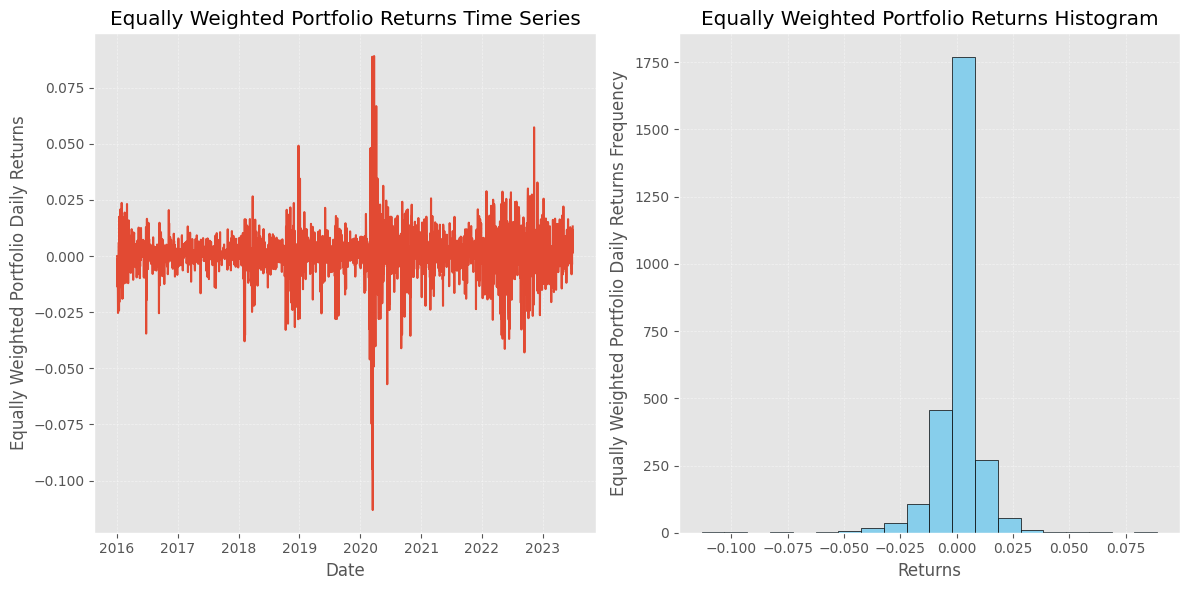

In [190]:
PlotDynamics.plot_returns_ts_hist(market_cap_weighted_portfolio['returns'], "Equally Weighted Portfolio")

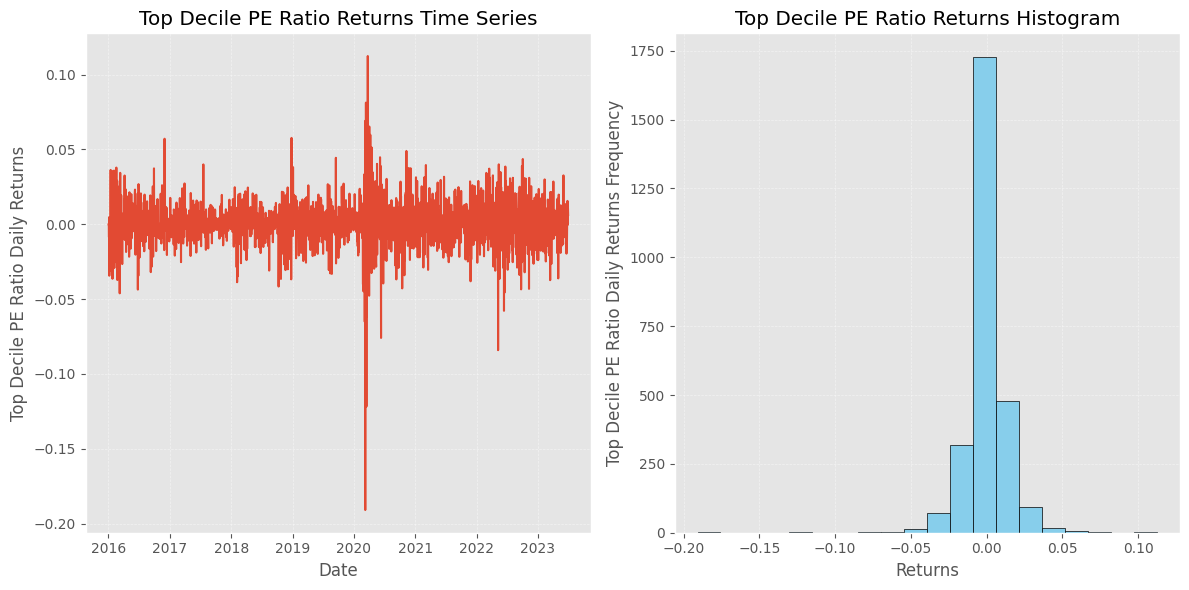

In [191]:
PlotDynamics.plot_returns_ts_hist(top_decile_pe_portfolio['returns'], "Top Decile PE Ratio")

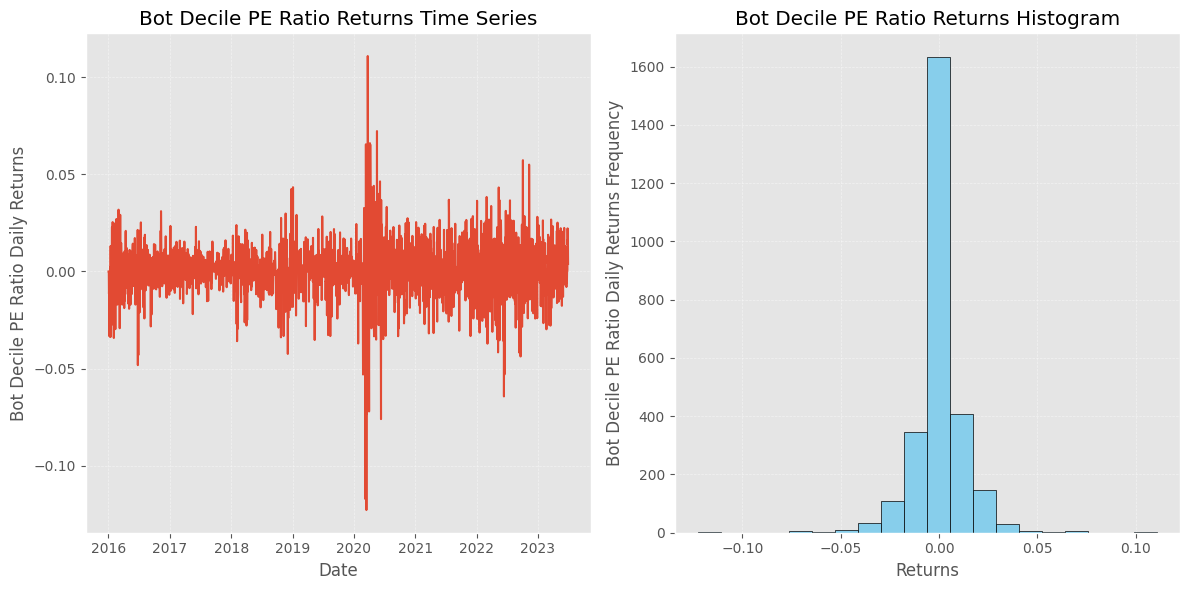

In [192]:
PlotDynamics.plot_returns_ts_hist(bot_decile_pe_portfolio['returns'], "Bot Decile PE Ratio")

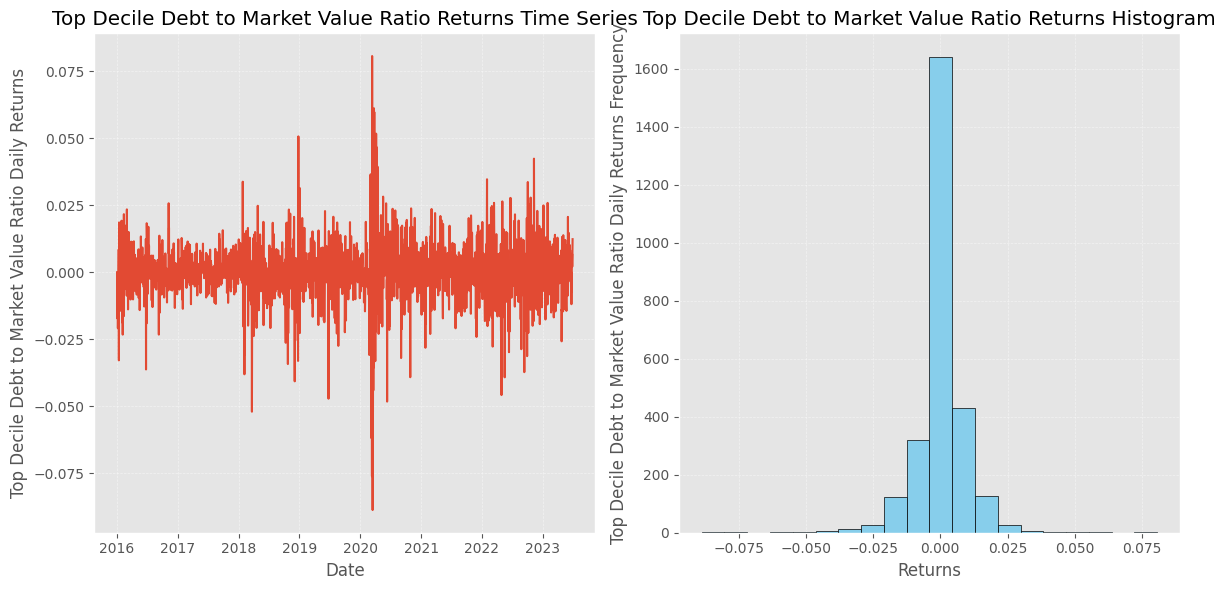

In [193]:
PlotDynamics.plot_returns_ts_hist(top_decile_debt_mktval_portfolio['returns'], "Top Decile Debt to Market Value Ratio")

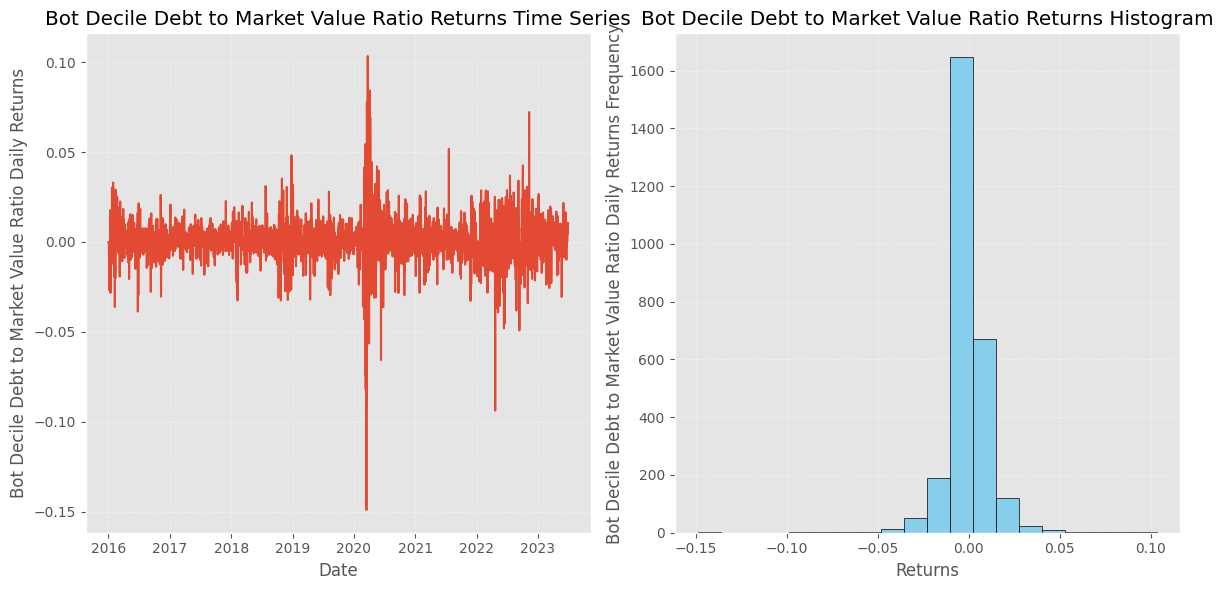

In [194]:
PlotDynamics.plot_returns_ts_hist(bot_decile_debt_mktval_portfolio['returns'], "Bot Decile Debt to Market Value Ratio")

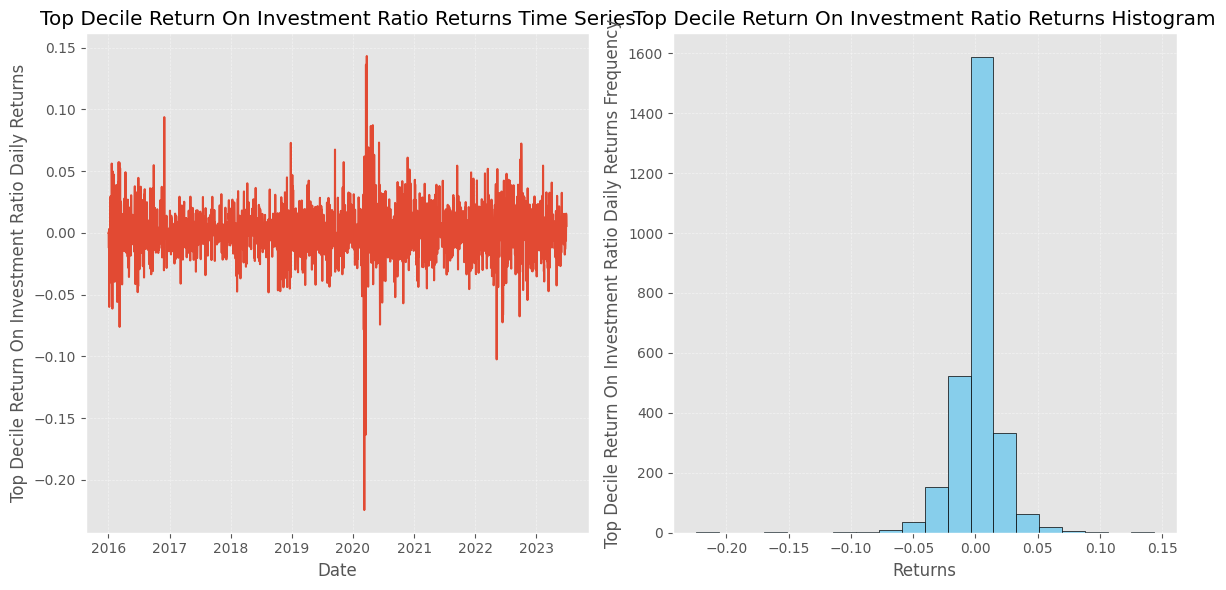

In [195]:
PlotDynamics.plot_returns_ts_hist(top_decile_ret_invst_portfolio['returns'], "Top Decile Return On Investment Ratio")

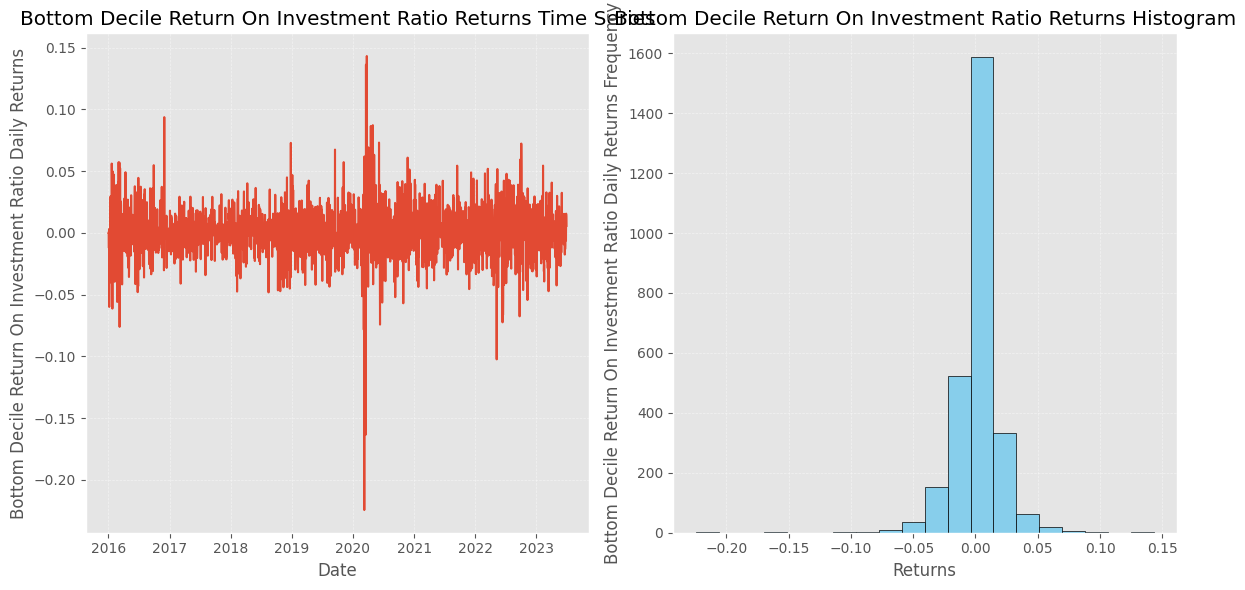

In [196]:
PlotDynamics.plot_returns_ts_hist(bot_decile_ret_invst_portfolio['returns'], "Bottom Decile Return On Investment Ratio")

#### **C. Spread Dynamics**

To better understand the dynamics of the spread and the signal processing, we will plot the M day (one of our parameters) returns of each component in our spread. We will also take a look at the time series of the spread over our time period of interest.

In [199]:
# top_decile_ret_invst_portfolio['moving_mkt_val']
bot_decile_ret_invst_portfolio['moving_mkt_val']

tradable_date
2016-01-01    95,911.2700
2016-01-02    95,911.2700
2016-01-03    95,911.2700
2016-01-04    94,732.5179
2016-01-05    95,017.3795
                 ...     
2023-06-26   203,174.1771
2023-06-27   201,885.4976
2023-06-28   205,009.0569
2023-06-29   207,784.5371
2023-06-30   208,939.7264
Name: moving_mkt_val, Length: 2738, dtype: float64

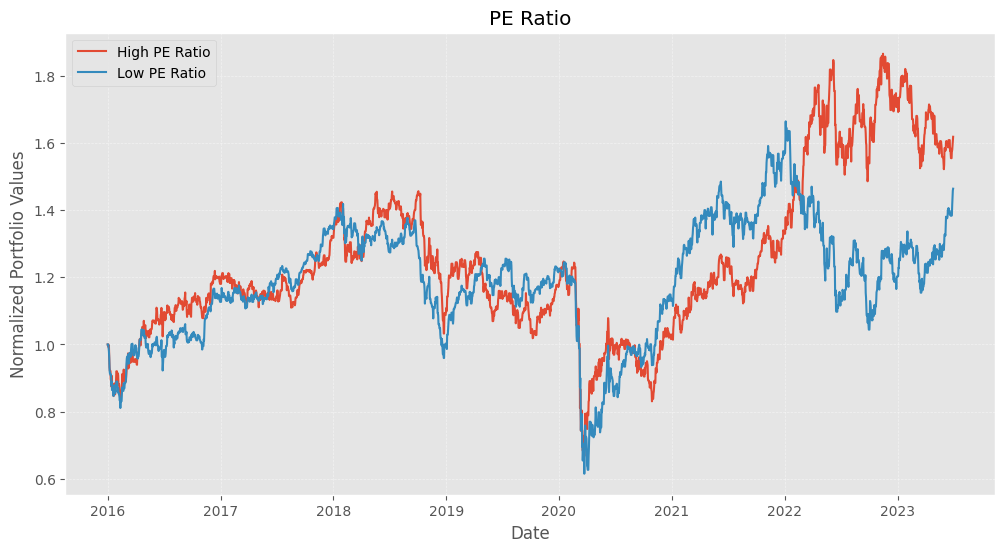

In [205]:
PlotDynamics.plot_multiple_ts(
    [
        
        top_decile_pe_portfolio['moving_mkt_val'] / top_decile_pe_portfolio['moving_mkt_val'].iloc[0],
        bot_decile_pe_portfolio['moving_mkt_val'] / bot_decile_pe_portfolio['moving_mkt_val'].iloc[0],
    ],
    [
        f'High PE Ratio',
        f'Low PE Ratio'
    ],
    xlabel="Date",
    ylabel=f"Normalized Portfolio Values",
    title=f"PE Ratio"
)


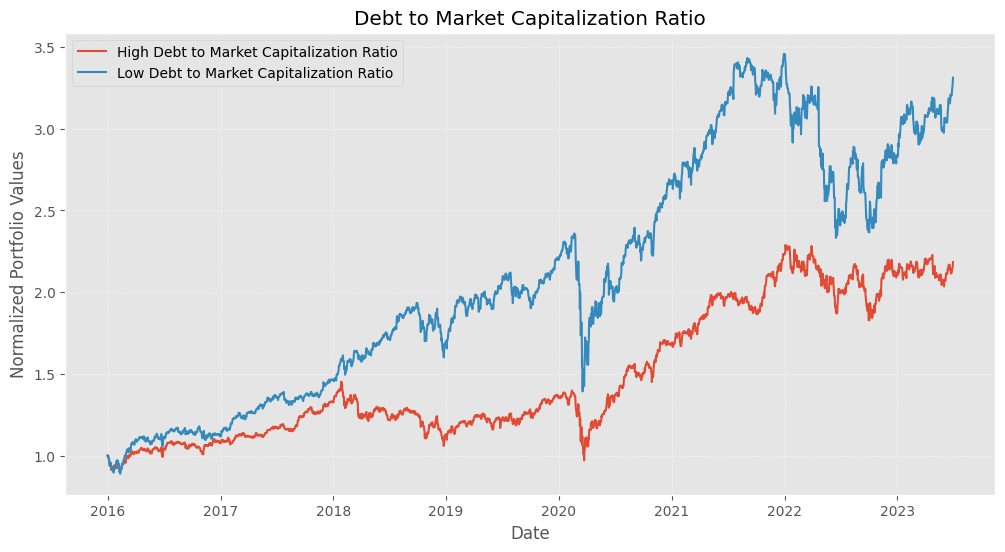

In [206]:
PlotDynamics.plot_multiple_ts(
    [
        
        top_decile_debt_mktval_portfolio['moving_mkt_val'] / top_decile_debt_mktval_portfolio['moving_mkt_val'].iloc[0],
        bot_decile_debt_mktval_portfolio['moving_mkt_val'] / bot_decile_debt_mktval_portfolio['moving_mkt_val'].iloc[0],
    ],
    [
        f'High Debt to Market Capitalization Ratio',
        f'Low Debt to Market Capitalization Ratio'
    ],
    xlabel="Date",
    ylabel=f"Normalized Portfolio Values",
    title=f"Debt to Market Capitalization Ratio"
)

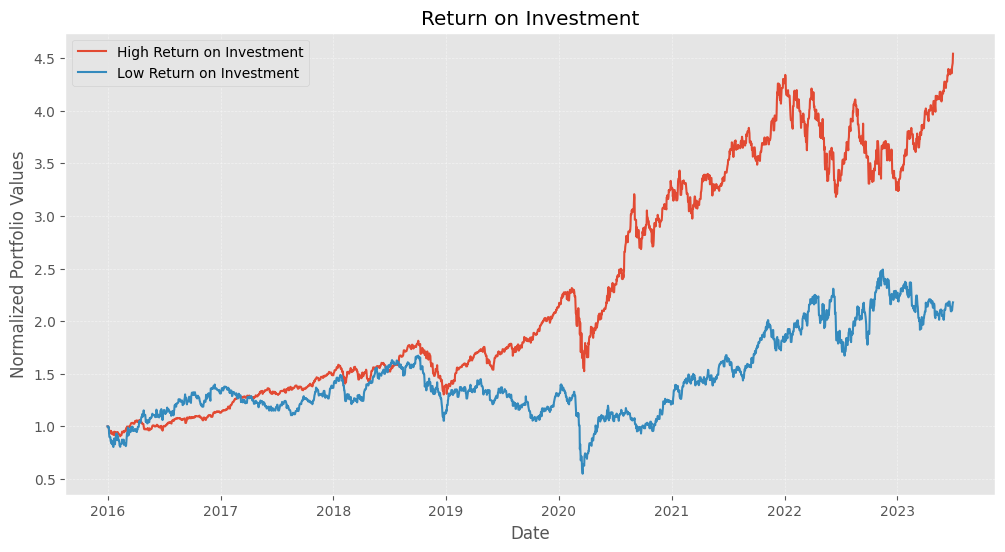

In [209]:
PlotDynamics.plot_multiple_ts(
    [
        
        top_decile_ret_invst_portfolio['moving_mkt_val'] / top_decile_ret_invst_portfolio['moving_mkt_val'].iloc[0],
        bot_decile_ret_invst_portfolio['moving_mkt_val'] / bot_decile_ret_invst_portfolio['moving_mkt_val'].iloc[0],
    ],
    [
        f'High Return on Investment',
        f'Low Return on Investment'
    ],
    xlabel="Date",
    ylabel=f"Normalized Portfolio Values",
    title=f"Return on Investment"
)

In [ ]:
# Spread of Returns
return_spread_df = pd.merge(
    ticker1_df[['adj_close', 'returns', f'{Parameters.M}_day_returns', 'trailing_15_day_dollar_volume']], 
    ticker2_df[['adj_close', 'returns', f'{Parameters.M}_day_returns', 'trailing_15_day_dollar_volume']], 
    how='outer', left_index=True, right_index=True, 
    suffixes=(f'_{SpreadTicker.ticker1}', f'_{SpreadTicker.ticker2}')
)

return_spread_df[f'{Parameters.M}_day_returns_spread'] = return_spread_df[ f'{Parameters.M}_day_returns_{SpreadTicker.ticker1}'] - return_spread_df[ f'{Parameters.M}_day_returns_{SpreadTicker.ticker2}']

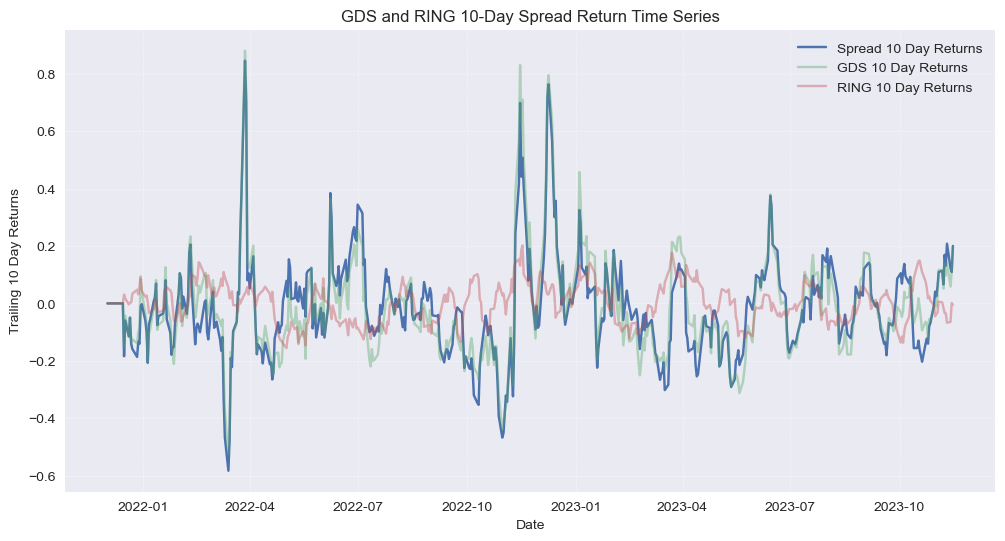

In [ ]:
PlotDynamics.plot_multiple_ts(
    [
        return_spread_df[f'{Parameters.M}_day_returns_spread'],
        ticker1_df[f'{Parameters.M}_day_returns'],
        ticker2_df[f'{Parameters.M}_day_returns'],
    ],
    [
        f'Spread {Parameters.M} Day Returns',
        f'{SpreadTicker.ticker1} {Parameters.M} Day Returns',
        f'{SpreadTicker.ticker2} {Parameters.M} Day Returns'
    ],
    xlabel="Date",
    ylabel=f"Trailing {Parameters.M} Day Returns",
    title=f"{SpreadTicker.ticker1} and {SpreadTicker.ticker2} {Parameters.M}-Day Spread Return Time Series",
    alphas=[1,0.4,0.4]
)


## IV. Strategy and Implementation:

### 1. Strategy Overview

***
**Profit Component:**

Our quantitative trading strategy here will be to use the spread of the M-day (set in our parameters) returns between our 2 ETFs as a signal. If the absolute value of the spread exceeds our entry point `Parameters.G`, we will enter into a long or short position (depending on whether the signal is positive or negative). Conversely, if the absolute value of the spread falls below our exit point `Parameters.J`, we will exit the position for a profit.

***
**Risk Management Component:**

I have 2 possible risk management strategies for this implementation. 

The first one is given by `Parameters.TRAILING_STOP` where if the profit and loss of our current position for the day drops below this paramter times the gross traded volume of our position, we will exit the position for a loss.

The second one is given by `Parameters.S` which is a signal from the return spread. This parameter will be a fixed constant, if exceeded, then we will enter into a neutral position.

Both these risk management strategies will exit the position and stay neutral for the remainder of the month.
***

### 2. Signal Processing: Entry, Exit, Stop Limit

***
**Entry:**

We will enter into a position, buying `SpreadTicker.ticker1` (GDS) and shorting `SpreadTicker.ticker2` (RING) if the `Parameters.M` day return spread exceeds `Parameters.G`.

Converesely, we will enter into a position, shorting `SpreadTicker.ticker1` (GDS) and buying `SpreadTicker.ticker2` (RING) if the `Parameters.M` day spread falls below -`Parameters.G` (negative).

***
**Exit:**

We will exit the position if the `Parameters.M` day return spread falls below `Parameters.J` from its corresponding side. 

That is, if we currently have a long position in `SpreadTicker.ticker1` (GDS) and a short position in `SpreadTicker.ticker2` (RING), we will exit if the spread fallse below `Parameters.J`.

Conversely, if we currently have a short position in `SpreadTicker.ticker1` (GDS) and a long position in `SpreadTicker.ticker2` (RING), we will exit if the spread rises above -`Parameters.J` (negative).

***
**Stop Limit:**

We will enforce a stop limit, `Parameters.S`. If the absolute value of the `Parameters.M` day return spread of `SpreadTicker.ticker1` and `SpreadTicker.ticker2` exceed this stop limit, we will exit the position and refrain from entering back into another position until the first day of the next month.
***

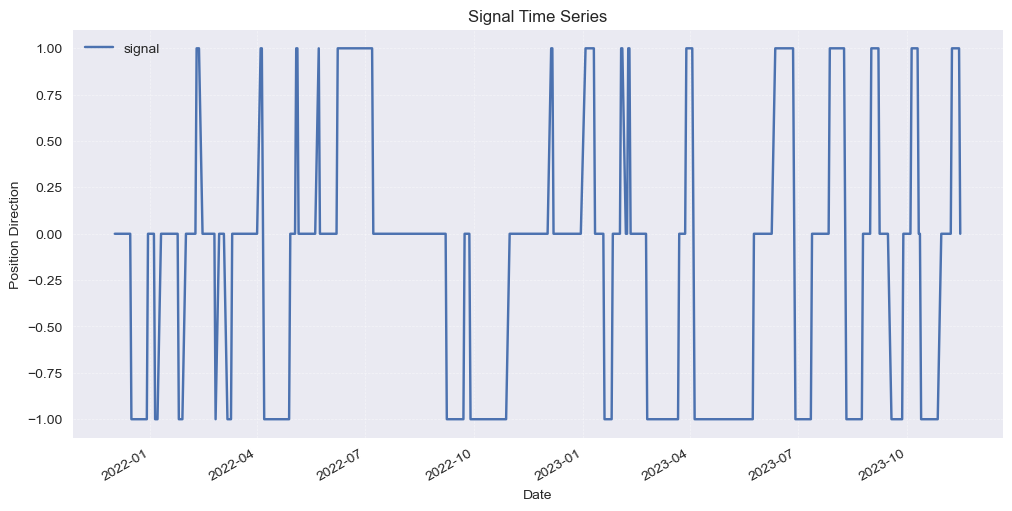

In [ ]:
signal_series = Processing.generate_signal(return_spread_df[f'{Parameters.M}_day_returns_spread'], Parameters.G, Parameters.J, Parameters.S)
signal_series.plot.line(
    xlabel=f"Date", 
    ylabel=f"Position Direction", 
    title="Signal Time Series", 
    figsize=(12,6)
)
plt.legend()
plt.show()

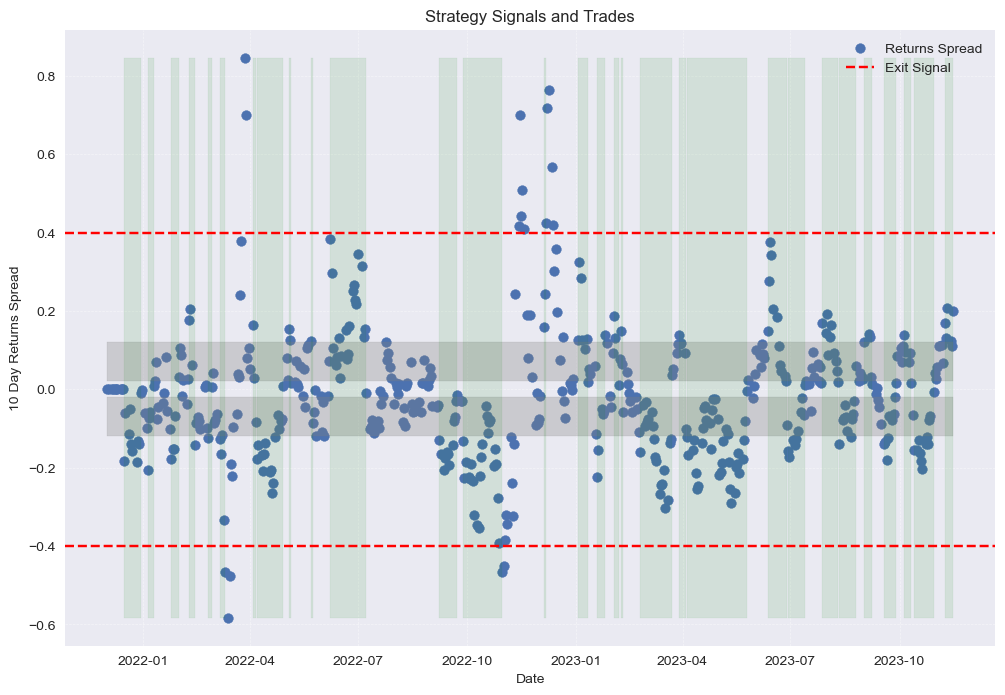

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(x=return_spread_df.index, y=return_spread_df[f'{Parameters.M}_day_returns_spread'], label='Returns Spread')

# Add horizontal lines
plt.axhline(y=Parameters.S, color='r', linestyle='--', label='Exit Signal')
plt.axhline(y=-Parameters.S, color='r', linestyle='--')

plt.fill_between(return_spread_df.index, y1=Parameters.J, y2=Parameters.G, color='gray', alpha=0.3)
plt.fill_between(return_spread_df.index, y1=-Parameters.G, y2=-Parameters.J, color='gray', alpha=0.3)

prev_signal = 0
prev_date = None
for date, signal in signal_series.items():
    if signal != prev_signal and prev_signal == 0:
        prev_date = date
    elif signal != prev_signal and prev_signal != 0 and prev_date is not None:
        plt.fill_betweenx(y=np.linspace(
            np.nanmin(return_spread_df[f'{Parameters.M}_day_returns_spread']),
            np.nanmax(return_spread_df[f'{Parameters.M}_day_returns_spread'])
        ), x1=prev_date, x2=date, color='green', alpha=0.1
        )
        prev_date = None
    prev_signal = signal

# Customize the plot as needed
plt.xlabel('Date')
plt.ylabel(f'{Parameters.M} Day Returns Spread')
plt.title('Strategy Signals and Trades')
plt.legend()

# Show the plot
plt.show()

### 3. Position Sizing

***
**Determining Position Size:**

To determin position size, we will use a metric that was introduced in part II of this report, `15_day_trailing_dollar_volume`, which indicates the median of the past 15 days' trading volume on the less liquid of the pair. This ensures that we are not taking up all the liquidity of the market. 

We will size our position to be `15_day_trailing_dollar_volume / 100` to get the dollar amount to be traded. Then we simply buy the closest integer number of shares of the ETF we are taking a long position in such that the dollar amount of the purchase is closest to the dollar amount to be traded. Inversely, we sell the closest integer number of shares of the ETF we are taking a short position in such that the dollar amount of the purchase is closest to the dollar amount to be traded.

We will end with approximately `2 * 15_day_trailing_dollar_volume / 100` gross dollars traded to enter into the position.
***

### 4. Parameter Tuning

***
In this section we will test out different parameters by performing a grid search of the parameters for a strategy with both the stop limit and trailing stop loss risk management parameters in place.

In [ ]:
return_spread_df['dollar_amount_to_purchase'] = return_spread_df[f'trailing_15_day_dollar_volume_{lower_volume_ticker}'] / 100
return_spread_df[f'shares_to_purchase_{SpreadTicker.ticker1}'] = round(return_spread_df['dollar_amount_to_purchase'] / return_spread_df[f'adj_close_{SpreadTicker.ticker1}'], 0)
return_spread_df[f'shares_to_purchase_{SpreadTicker.ticker2}'] = round(return_spread_df['dollar_amount_to_purchase'] / return_spread_df[f'adj_close_{SpreadTicker.ticker2}'], 0)

In [ ]:
best_j = None
best_g = None
best_s = None
best_ts = None
best_pl = float('-inf')

tune_j = [0.02, 0.04,0.06]
tune_g = [0.12, 0.14, 0.16]
tune_s = [0.4, 0.5, 0.6]
tune_ts = [0.03, 0.05, 0.1]

for j in tune_j:
    for g in tune_g:
        for s in tune_s:
            for ts in tune_ts:
                signal_series = Processing.generate_signal(return_spread_df[f'{Parameters.M}_day_returns_spread'], g, j, s)
                strat_df = Processing.generate_holdings_pnl(
                    return_spread_df[f'adj_close_{SpreadTicker.ticker1}'],
                    return_spread_df[f'adj_close_{SpreadTicker.ticker2}'],
                    return_spread_df[f'shares_to_purchase_{SpreadTicker.ticker1}'],
                    return_spread_df[f'shares_to_purchase_{SpreadTicker.ticker2}'],
                    f'{SpreadTicker.ticker1}',
                    f'{SpreadTicker.ticker2}',
                    signal_series,
                    trailing_stop=ts
                )
                pl = strat_df['PnL'].iloc[-1]
                if pl > best_pl:
                    best_pl = pl
                    best_j = j
                    best_g = g
                    best_s = s
                    best_ts = ts
display("Best Parameters")
display(best_j)
display(best_g)
display(best_s)
display(best_ts)

'Best Parameters'

0.02

0.12

0.6

0.1

### 5. Trade Performance

***
**No Stop Limits or Trailing Stop Losses**

In this strategy, we will refrain from deploying any risk management measures and assess the performance of the profit side of the trading strategy without imposing any stop limits or trailing stop losses.

***
**Stop Limit without Trailing Stop Loss**

In this variant, we will introduce a stop limit to curtail potential losses, but without the additional safeguard of a trailing stop loss. This approach aims to test the effectiveness of a stop limit in limiting downside risk.

***
**Trailing Stop Loss without Stop Limit**

Conversely, this strategy involves implementing a trailing stop loss mechanism without the use of stop limits. The focus is on evaluating the impact of trailing stop losses alone on the trading strategy's performance.

***
**Both Trailing Stop Losses and Stop Limits**

In this comprehensive risk management approach, both trailing stop losses and stop limits will be incorporated. This strategy seeks to strike a balance between limiting losses and securing profits, offering a more nuanced risk mitigation strategy.

Each of these variations will be analyzed to gain insights into how different risk management techniques influence the overall performance and risk profile of the trading strategy.

***
**Trading Costs**

Trading costs will be incured based off the `Parameters.ZETA` set at the beginning of the report. It will be multiplied by the gross amount traded as the transaction fee on every entry and exit of a trade.

#### A. No Stop Limits or Trailing Stop Losses
***

#### **Strategy Performance** 
 ***


    We can see that the no-risk management strategy has some pretty large sudden draw downs when the market is volatile, however, it continues to recover and 
    perform pretty well.


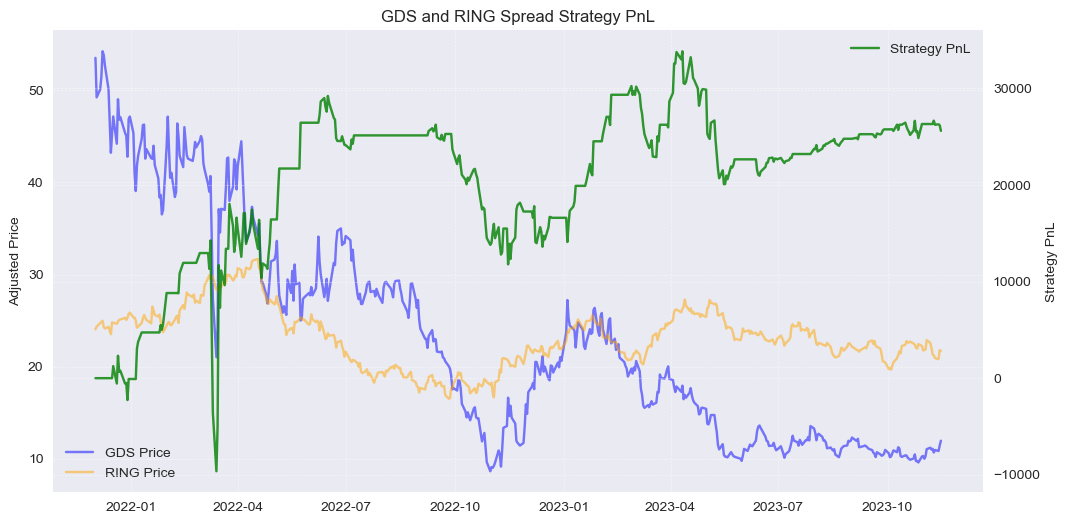

In [ ]:
display(Markdown(f"#### **Strategy Performance** \n ***"))
display(Markdown(f"""
    We can see that the no-risk management strategy has some pretty large sudden draw downs when the market is volatile, however, it continues to recover and 
    perform pretty well.
"""))

signal_series = Processing.generate_signal(return_spread_df[f'{Parameters.M}_day_returns_spread'], Parameters.G, Parameters.J)
no_sl_no_tsl_strat_pnl_pos_df = Processing.generate_holdings_pnl(
    return_spread_df[f'adj_close_{SpreadTicker.ticker1}'],
    return_spread_df[f'adj_close_{SpreadTicker.ticker2}'],
    return_spread_df[f'shares_to_purchase_{SpreadTicker.ticker1}'],
    return_spread_df[f'shares_to_purchase_{SpreadTicker.ticker2}'],
    f'{SpreadTicker.ticker1}',
    f'{SpreadTicker.ticker2}',
    signal_series,
    trailing_stop=float('inf')
)

pl_series = no_sl_no_tsl_strat_pnl_pos_df['PnL']

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(return_spread_df.index, return_spread_df[f'adj_close_{SpreadTicker.ticker1}'], color='blue', alpha=0.5, label=f'{SpreadTicker.ticker1} Price')
ax1.plot(return_spread_df.index, return_spread_df[f'adj_close_{SpreadTicker.ticker2}'], color='orange', alpha=0.5, label=f'{SpreadTicker.ticker2} Price')
plt.legend(loc='lower left')
ax2 = ax1.twinx()
ax2.plot(pl_series.index, pl_series, color='green', alpha=0.8, label=f'Strategy PnL')
ax1.set_ylabel("Adjusted Price")
ax2.set_ylabel("Strategy PnL")
plt.legend(loc='upper right')
plt.title(f'{SpreadTicker.ticker1} and {SpreadTicker.ticker2} Spread Strategy PnL')
plt.show()

#### **PnL and Trade Windows** 
 ***


    The trade windows in this trading strategy will most likely be the widest since there are no risk management strategies in place to close trades early when
    the trade is going south. This may not be good since trades can get out of hand and require a margin call in certain cases.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


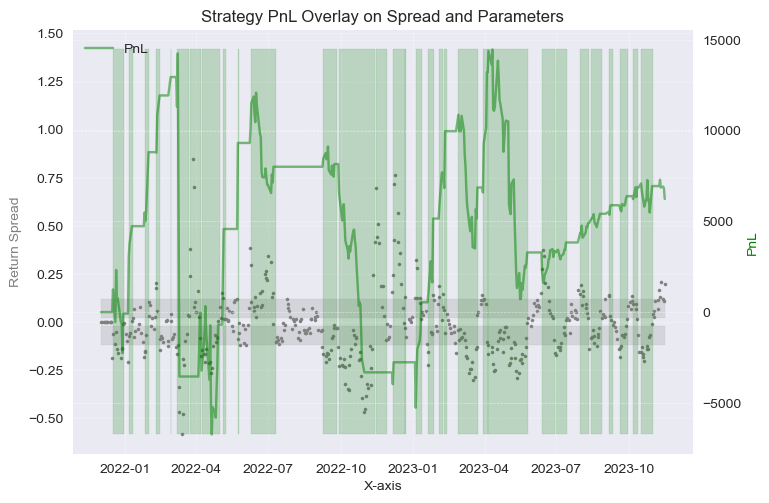

In [ ]:
display(Markdown(f"#### **PnL and Trade Windows** \n ***"))
display(Markdown(f"""
    The trade windows in this trading strategy will most likely be the widest since there are no risk management strategies in place to close trades early when
    the trade is going south. This may not be good since trades can get out of hand and require a margin call in certain cases.
"""))

line_alpha = 0.5
box_alpha = 0.2
fig, ax1 = plt.subplots()

# Plot the first data on the primary y-axis
ax1.scatter(return_spread_df.index, return_spread_df[f'{Parameters.M}_day_returns_spread'], color='gray', s=5)
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Return Spread', color='gray')
plt.legend(loc='upper right')

ax1.fill_between(return_spread_df.index, y1=Parameters.J, y2=Parameters.G, color='gray', alpha=box_alpha)
ax1.fill_between(return_spread_df.index, y1=-Parameters.G, y2=-Parameters.J, color='gray', alpha=box_alpha)

# TRADES FROM HOLDINGS
holdings_df = no_sl_no_tsl_strat_pnl_pos_df[[f'{SpreadTicker.ticker1}', f'{SpreadTicker.ticker2}']]
prev_holding = 0
prev_date = None
for date, holding in holdings_df[f'{SpreadTicker.ticker1}'].items():
    if holding != prev_holding and prev_holding == 0:
        prev_date = date
    elif holding != prev_holding and prev_holding != 0 and prev_date is not None:
        ax1.fill_betweenx(y=np.arange(
            np.nanmin(return_spread_df[f'{Parameters.M}_day_returns_spread']),
            np.nanmax(return_spread_df[f'{Parameters.M}_day_returns_spread']) + 1
        ), x1=prev_date, x2=date, color='green', alpha=box_alpha
        )
        prev_date = None
    prev_holding = holding

# Create a second y-axis (twin axes)
ax2 = ax1.twinx()
ax2.plot(pl_series.index, pl_series, color='green', label='PnL', alpha=line_alpha)
ax2.set_ylabel('PnL', color='green')

# Customize the plot
plt.title('Strategy PnL Overlay on Spread and Parameters')
plt.legend(loc='upper left')

# Show the plot
plt.show()

#### B. Stop Limit without Trailing Stop Loss
***

#### **Strategy Performance** 
 ***


    We can see that the stop limit risk management strategy has a much smaller y-axis due to the stop limit discouraging trades outside the bounds of the set
    limit, however, the PnL is significantly smaller on this strategy as well.


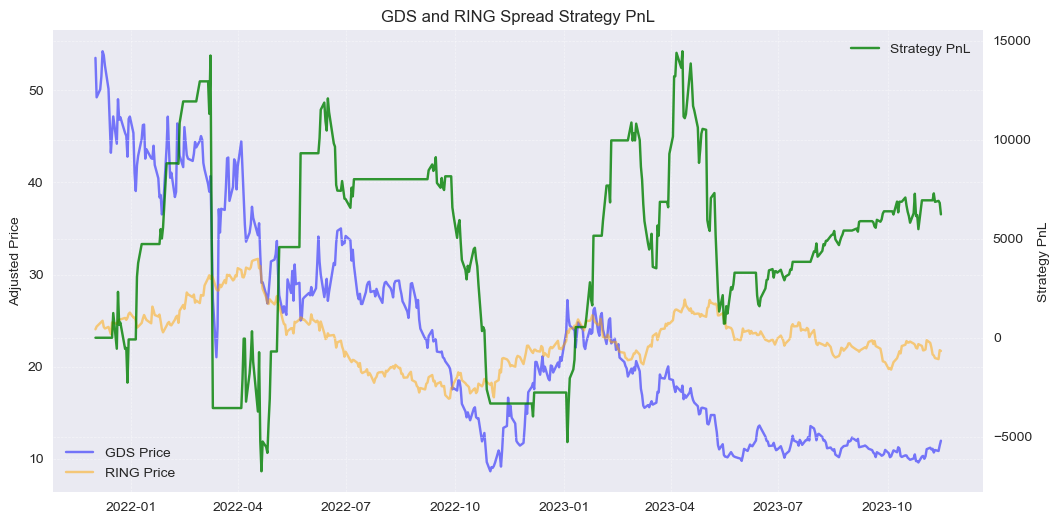

In [ ]:
display(Markdown(f"#### **Strategy Performance** \n ***"))
display(Markdown(f"""
    We can see that the stop limit risk management strategy has a much smaller y-axis due to the stop limit discouraging trades outside the bounds of the set
    limit, however, the PnL is significantly smaller on this strategy as well.
"""))

signal_series = Processing.generate_signal(return_spread_df[f'{Parameters.M}_day_returns_spread'], Parameters.G, Parameters.J, Parameters.S)
sl_no_tsl_strat_pnl_pos_df = Processing.generate_holdings_pnl(
    return_spread_df[f'adj_close_{SpreadTicker.ticker1}'],
    return_spread_df[f'adj_close_{SpreadTicker.ticker2}'],
    return_spread_df[f'shares_to_purchase_{SpreadTicker.ticker1}'],
    return_spread_df[f'shares_to_purchase_{SpreadTicker.ticker2}'],
    f'{SpreadTicker.ticker1}',
    f'{SpreadTicker.ticker2}',
    signal_series,
    trailing_stop=float('inf')
)

pl_series = sl_no_tsl_strat_pnl_pos_df['PnL']

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(return_spread_df.index, return_spread_df[f'adj_close_{SpreadTicker.ticker1}'], color='blue', alpha=0.5, label=f'{SpreadTicker.ticker1} Price')
ax1.plot(return_spread_df.index, return_spread_df[f'adj_close_{SpreadTicker.ticker2}'], color='orange', alpha=0.5, label=f'{SpreadTicker.ticker2} Price')
plt.legend(loc='lower left')
ax2 = ax1.twinx()
ax2.plot(pl_series.index, pl_series, color='green', alpha=0.8, label=f'Strategy PnL')
ax1.set_ylabel("Adjusted Price")
ax2.set_ylabel("Strategy PnL")
plt.legend(loc='upper right')
plt.title(f'{SpreadTicker.ticker1} and {SpreadTicker.ticker2} Spread Strategy PnL')
plt.show()

#### **PnL and Trade Windows** 
 ***


    We can see that the trade windows are pretty large with the stop limit strategy. This is because the stop limit is only attempting to prevent the strategy from
    trading when the return spread is abnormally large. The reason for this is to prevent the strategy from trading in very uncertain market conditions.


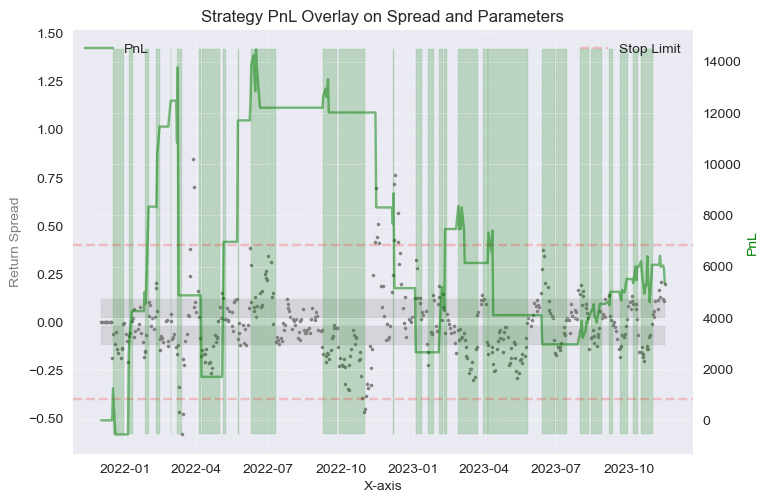

In [ ]:
display(Markdown(f"#### **PnL and Trade Windows** \n ***"))
display(Markdown(f"""
    We can see that the trade windows are pretty large with the stop limit strategy. This is because the stop limit is only attempting to prevent the strategy from
    trading when the return spread is abnormally large. The reason for this is to prevent the strategy from trading in very uncertain market conditions.
"""))

line_alpha = 0.5
box_alpha = 0.2
fig, ax1 = plt.subplots()

# Plot the first data on the primary y-axis
ax1.scatter(return_spread_df.index, return_spread_df[f'{Parameters.M}_day_returns_spread'], color='gray', s=5)
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Return Spread', color='gray')
ax1.axhline(y=Parameters.S, color='r', linestyle='--', label='Stop Limit', alpha=box_alpha)
ax1.axhline(y=-Parameters.S, color='r', linestyle='--', alpha=box_alpha)
plt.legend(loc='upper right')

ax1.fill_between(return_spread_df.index, y1=Parameters.J, y2=Parameters.G, color='gray', alpha=box_alpha)
ax1.fill_between(return_spread_df.index, y1=-Parameters.G, y2=-Parameters.J, color='gray', alpha=box_alpha)

# TRADES FROM HOLDINGS
holdings_df = sl_no_tsl_strat_pnl_pos_df[[f'{SpreadTicker.ticker1}', f'{SpreadTicker.ticker2}']]
prev_holding = 0
prev_date = None
for date, holding in holdings_df[f'{SpreadTicker.ticker1}'].items():
    if holding != prev_holding and prev_holding == 0:
        prev_date = date
    elif holding != prev_holding and prev_holding != 0 and prev_date is not None:
        ax1.fill_betweenx(y=np.arange(
            np.nanmin(return_spread_df[f'{Parameters.M}_day_returns_spread']),
            np.nanmax(return_spread_df[f'{Parameters.M}_day_returns_spread']) + 1
        ), x1=prev_date, x2=date, color='green', alpha=box_alpha
        )
        prev_date = None
    prev_holding = holding


# Create a second y-axis (twin axes)
ax2 = ax1.twinx()
ax2.plot(pl_series.index, pl_series, color='green', label='PnL', alpha=line_alpha)
ax2.set_ylabel('PnL', color='green')

# Customize the plot
plt.title('Strategy PnL Overlay on Spread and Parameters')
plt.legend(loc='upper left')

# Show the plot
plt.show()

#### C. Trailing Stop Loss without Stop Limit
***

#### **Strategy Performance** 
 ***


    We can see that the trailing stop loss risk management strategy does not make as many trades. During volatile time periods, the trailing stop loss gets hit, and
    the strategy pauses for the month resulting in lower volatility of PnL but also lower returns.


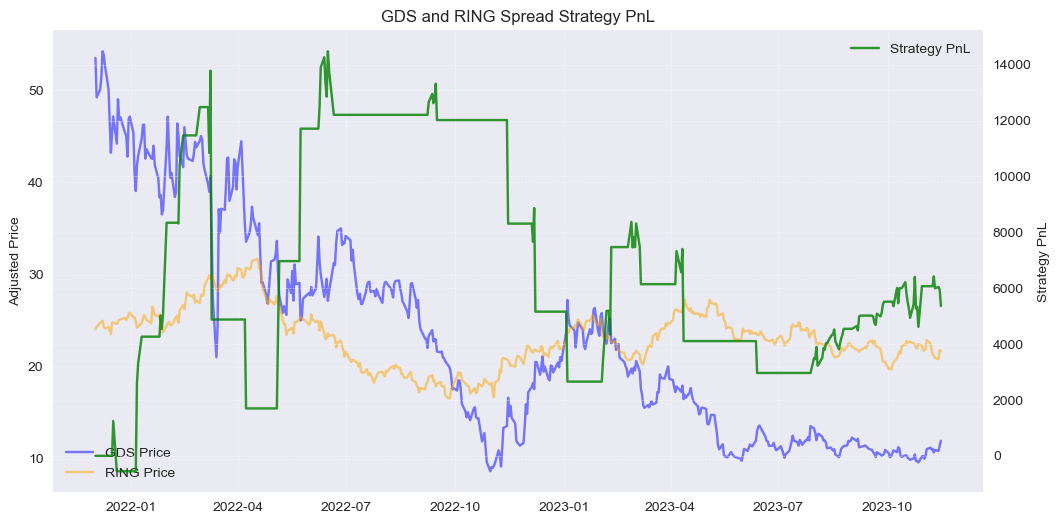

In [ ]:
display(Markdown(f"#### **Strategy Performance** \n ***"))
display(Markdown(f"""
    We can see that the trailing stop loss risk management strategy does not make as many trades. During volatile time periods, the trailing stop loss gets hit, and
    the strategy pauses for the month resulting in lower volatility of PnL but also lower returns.
"""))

signal_series = Processing.generate_signal(return_spread_df[f'{Parameters.M}_day_returns_spread'], Parameters.G, Parameters.J)
tsl_no_sl_strat_pnl_pos_df = Processing.generate_holdings_pnl(
    return_spread_df[f'adj_close_{SpreadTicker.ticker1}'],
    return_spread_df[f'adj_close_{SpreadTicker.ticker2}'],
    return_spread_df[f'shares_to_purchase_{SpreadTicker.ticker1}'],
    return_spread_df[f'shares_to_purchase_{SpreadTicker.ticker2}'],
    f'{SpreadTicker.ticker1}',
    f'{SpreadTicker.ticker2}',
    signal_series,
    trailing_stop=Parameters.TRAILING_STOP
)

pl_series = tsl_no_sl_strat_pnl_pos_df['PnL']

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(return_spread_df.index, return_spread_df[f'adj_close_{SpreadTicker.ticker1}'], color='blue', alpha=0.5, label=f'{SpreadTicker.ticker1} Price')
ax1.plot(return_spread_df.index, return_spread_df[f'adj_close_{SpreadTicker.ticker2}'], color='orange', alpha=0.5, label=f'{SpreadTicker.ticker2} Price')
plt.legend(loc='lower left')
ax2 = ax1.twinx()
ax2.plot(pl_series.index, pl_series, color='green', alpha=0.8, label=f'Strategy PnL')
ax1.set_ylabel("Adjusted Price")
ax2.set_ylabel("Strategy PnL")
plt.legend(loc='upper right')
plt.title(f'{SpreadTicker.ticker1} and {SpreadTicker.ticker2} Spread Strategy PnL')
plt.show()

#### **PnL and Trade Windows** 
 ***


    We can see in this trade window chart all the small windows the strategy takes to trade. The windows are small due to the risk management strategy (stop loss),
    that is in place to keep the strategy from going rogue.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


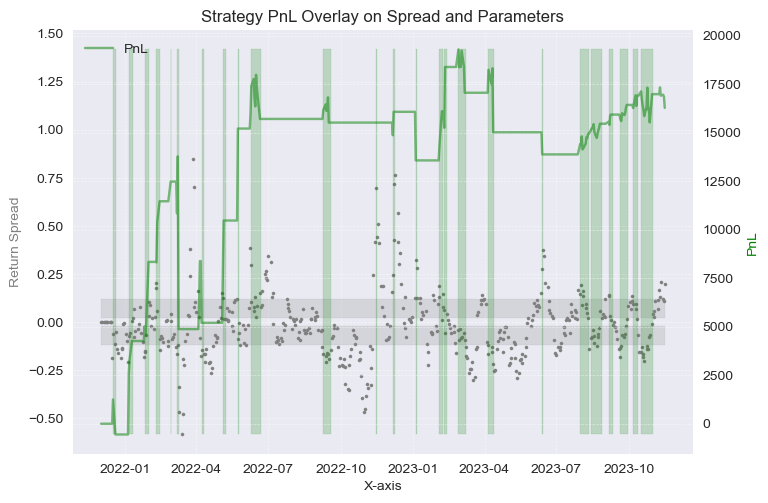

In [ ]:
display(Markdown(f"#### **PnL and Trade Windows** \n ***"))
display(Markdown(f"""
    We can see in this trade window chart all the small windows the strategy takes to trade. The windows are small due to the risk management strategy (stop loss),
    that is in place to keep the strategy from going rogue.
"""))

line_alpha = 0.5
box_alpha = 0.2
fig, ax1 = plt.subplots()

# Plot the first data on the primary y-axis
ax1.scatter(return_spread_df.index, return_spread_df[f'{Parameters.M}_day_returns_spread'], color='gray', s=5)
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Return Spread', color='gray')
plt.legend(loc='upper right')

ax1.fill_between(return_spread_df.index, y1=Parameters.J, y2=Parameters.G, color='gray', alpha=box_alpha)
ax1.fill_between(return_spread_df.index, y1=-Parameters.G, y2=-Parameters.J, color='gray', alpha=box_alpha)

# TRADES FROM HOLDINGS
holdings_df = tsl_no_sl_strat_pnl_pos_df[[f'{SpreadTicker.ticker1}', f'{SpreadTicker.ticker2}']]
prev_holding = 0
prev_date = None
for date, holding in holdings_df[f'{SpreadTicker.ticker1}'].items():
    if holding != prev_holding and prev_holding == 0:
        prev_date = date
    elif holding != prev_holding and prev_holding != 0 and prev_date is not None:
        ax1.fill_betweenx(y=np.arange(
            np.nanmin(return_spread_df[f'{Parameters.M}_day_returns_spread']),
            np.nanmax(return_spread_df[f'{Parameters.M}_day_returns_spread']) + 1
        ), x1=prev_date, x2=date, color='green', alpha=box_alpha
        )
        prev_date = None
    prev_holding = holding


# Create a second y-axis (twin axes)
ax2 = ax1.twinx()
ax2.plot(pl_series.index, pl_series, color='green', label='PnL', alpha=line_alpha)
ax2.set_ylabel('PnL', color='green')

# Customize the plot
plt.title('Strategy PnL Overlay on Spread and Parameters')
plt.legend(loc='upper left')

# Show the plot
plt.show()

#### D. Both Trailing Stop Losses and Stop Limits
***

#### **Strategy Performance** 
 ***


    We can see that deploying both risk management strategies gives us a pretty good result! It maintains a good balance between staying out of the market as well
    as getting in when there is an opportunity. It also reduces the size of the large drawdowns seen from the no-risk management strategy.

    NOTE: We will continue to use and analyze this strategy since it works well and makes good use of the risk management for the safety of its PnL.


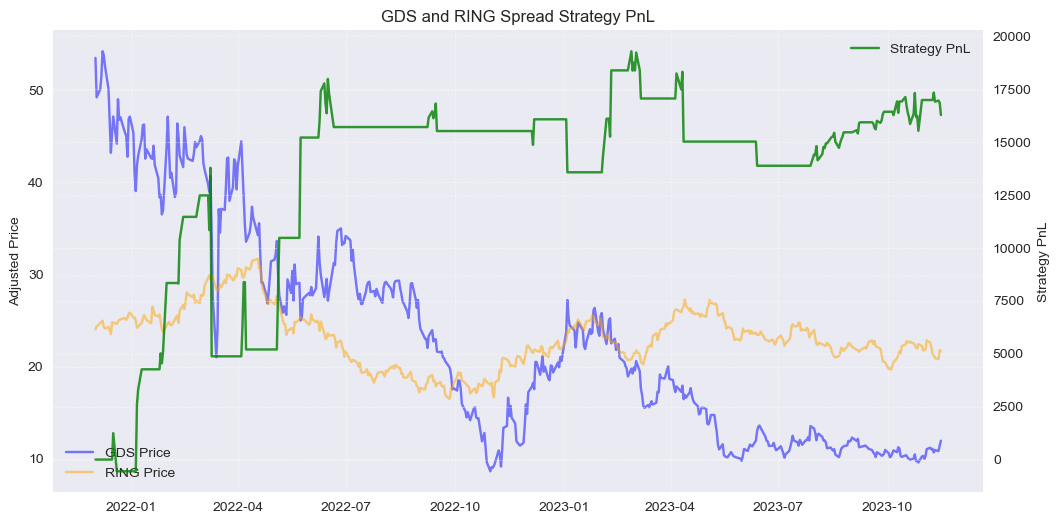

In [ ]:
display(Markdown(f"#### **Strategy Performance** \n ***"))
display(Markdown(f"""
    We can see that deploying both risk management strategies gives us a pretty good result! It maintains a good balance between staying out of the market as well
    as getting in when there is an opportunity. It also reduces the size of the large drawdowns seen from the no-risk management strategy.

    NOTE: We will continue to use and analyze this strategy since it works well and makes good use of the risk management for the safety of its PnL.
"""))

signal_series = Processing.generate_signal(return_spread_df[f'{Parameters.M}_day_returns_spread'], Parameters.G, Parameters.J, Parameters.S)
sl_tsl_strat_pnl_pos_df = Processing.generate_holdings_pnl(
    return_spread_df[f'adj_close_{SpreadTicker.ticker1}'],
    return_spread_df[f'adj_close_{SpreadTicker.ticker2}'],
    return_spread_df[f'shares_to_purchase_{SpreadTicker.ticker1}'],
    return_spread_df[f'shares_to_purchase_{SpreadTicker.ticker2}'],
    f'{SpreadTicker.ticker1}',
    f'{SpreadTicker.ticker2}',
    signal_series,
    trailing_stop=Parameters.TRAILING_STOP
)

pl_series = sl_tsl_strat_pnl_pos_df['PnL']

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(return_spread_df.index, return_spread_df[f'adj_close_{SpreadTicker.ticker1}'], color='blue', alpha=0.5, label=f'{SpreadTicker.ticker1} Price')
ax1.plot(return_spread_df.index, return_spread_df[f'adj_close_{SpreadTicker.ticker2}'], color='orange', alpha=0.5, label=f'{SpreadTicker.ticker2} Price')
plt.legend(loc='lower left')
ax2 = ax1.twinx()
ax2.plot(pl_series.index, pl_series, color='green', alpha=0.8, label=f'Strategy PnL')
ax1.set_ylabel("Adjusted Price")
ax2.set_ylabel("Strategy PnL")
plt.legend(loc='upper right')
plt.title(f'{SpreadTicker.ticker1} and {SpreadTicker.ticker2} Spread Strategy PnL')
plt.show()

#### **PnL and Trade Windows** 
 ***


    This is a nice chart to display the trading windows our strategy takes. The windows are relatively small and the strategy constantly is able to get in and out of the
    market for profit, avoiding market risk when it can.


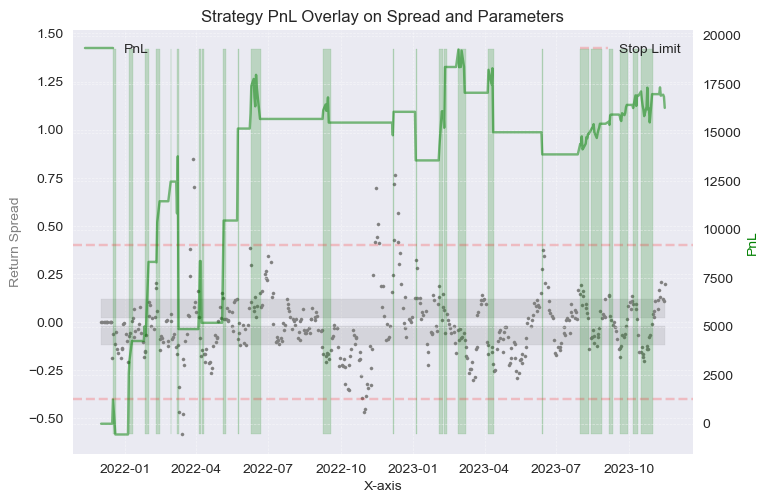

In [ ]:
display(Markdown(f"#### **PnL and Trade Windows** \n ***"))
display(Markdown(f"""
    This is a nice chart to display the trading windows our strategy takes. The windows are relatively small and the strategy constantly is able to get in and out of the
    market for profit, avoiding market risk when it can.
"""))

line_alpha = 0.5
box_alpha = 0.2
fig, ax1 = plt.subplots()

# Plot the first data on the primary y-axis
ax1.scatter(return_spread_df.index, return_spread_df[f'{Parameters.M}_day_returns_spread'], color='gray', s=5)

ax1.set_xlabel('X-axis')
ax1.set_ylabel('Return Spread', color='gray')
ax1.axhline(y=Parameters.S, color='r', linestyle='--', label='Stop Limit', alpha=box_alpha)
ax1.axhline(y=-Parameters.S, color='r', linestyle='--', alpha=box_alpha)
plt.legend(loc='upper right')

ax1.fill_between(return_spread_df.index, y1=Parameters.J, y2=Parameters.G, color='gray', alpha=box_alpha)
ax1.fill_between(return_spread_df.index, y1=-Parameters.G, y2=-Parameters.J, color='gray', alpha=box_alpha)

# TRADES FROM HOLDINGS
holdings_df = sl_tsl_strat_pnl_pos_df[[f'{SpreadTicker.ticker1}', f'{SpreadTicker.ticker2}']]
prev_holding = 0
prev_date = None
for date, holding in holdings_df[f'{SpreadTicker.ticker1}'].items():
    if holding != prev_holding and prev_holding == 0:
        prev_date = date
    elif holding != prev_holding and prev_holding != 0 and prev_date is not None:
        ax1.fill_betweenx(y=np.arange(
            np.nanmin(return_spread_df[f'{Parameters.M}_day_returns_spread']),
            np.nanmax(return_spread_df[f'{Parameters.M}_day_returns_spread']) + 1
        ), x1=prev_date, x2=date, color='green', alpha=box_alpha
        )
        prev_date = None
    prev_holding = holding


# Create a second y-axis (twin axes)
ax2 = ax1.twinx()
ax2.plot(pl_series.index, pl_series, color='green', label='PnL', alpha=line_alpha)
ax2.set_ylabel('PnL', color='green')

# Customize the plot
plt.title('Strategy PnL Overlay on Spread and Parameters')
plt.legend(loc='upper left')

# Show the plot
plt.show()

## V. Analysis of Trading Strategy:

### 1. Overview of Analysis

In this analysis we will cover the results of our trading strategy, the decomposition of our strategy using the Fama-French 3 Factor Model, and analyzing the correlation of our strategy with a volatility ETF (SVOL).

### 2. Decomposition using Fama-French 3 Factor Model

***
**Fama-French Three-Factor Model:**

The Fama-French Three-Factor Model is an asset pricing model developed by economists Eugene Fama and Kenneth French. It expands upon the Capital Asset Pricing Model (CAPM) by incorporating two additional factors to enhance the explanation of variations in stock returns.

**Three Factors:**

1. **Market Risk (Market Return - Risk-Free Rate):**
   - Represents exposure to the overall market.
   - Similar to CAPM, it captures systematic risk associated with the broad market.

2. **Size Factor (Small Minus Big, SMB):**
   - Represents historical excess returns of small-cap stocks over large-cap stocks.
   - Calculated as the difference in average returns between small and large-cap stocks.

3. **Value Factor (High Minus Low, HML):**
   - Represents historical excess returns of value stocks over growth stocks.
   - Calculated as the difference in average returns between high book-to-market (value) and low book-to-market (growth) stocks.

We will use the model to decompose the returns in our trading strategy to check whether our returns are heavily correlated with some of the 3 factors or if they are independent of the 3 factors.

***

In [ ]:
trading_strategy_performance_df: pd.DataFrame = pd.concat([return_spread_df, signal_series, pl_series], axis=1)
trading_strategy_performance_df['strategy_portfolio_value'] = trading_strategy_performance_df['PnL'] + (initial_capital/100)
trading_strategy_performance_df['strategy_portfolio_returns'] = trading_strategy_performance_df['strategy_portfolio_value'].pct_change()
trading_strategy_performance_df['strategy_portfolio_returns'].fillna(0, inplace=True)

### **Fama-French 3 Factors: Market Excess Returns** 
 ***


    From the market factor, we can see that the returns are very heavily centered around zero with a normal and symmetric distribution. This is as expected,
    since the market is expected to be somewhat efficient.


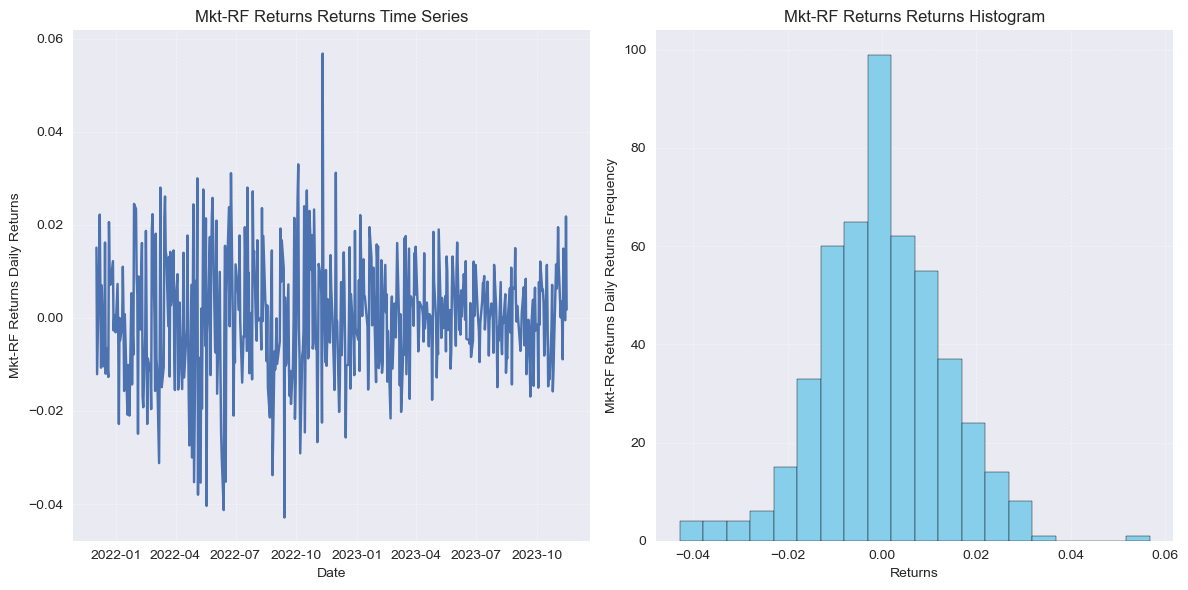

In [ ]:
display(Markdown(f"### **Fama-French 3 Factors: Market Excess Returns** \n ***"))
display(Markdown(f"""
    From the market factor, we can see that the returns are very heavily centered around zero with a normal and symmetric distribution. This is as expected,
    since the market is expected to be somewhat efficient.
"""))
PlotDynamics.plot_returns_ts_hist(
    ff3_df['Mkt-RF'], "Mkt-RF Returns"
)

### **Fama-French 3 Factors: Small Minus Big Returns** 
 ***


    From the distribution of SMB returns below,  we can see that the SMB returns during this period were close to normally distributed with a slight positive skew.
    Although, there seems to be high density of data points around slightly negative returns.


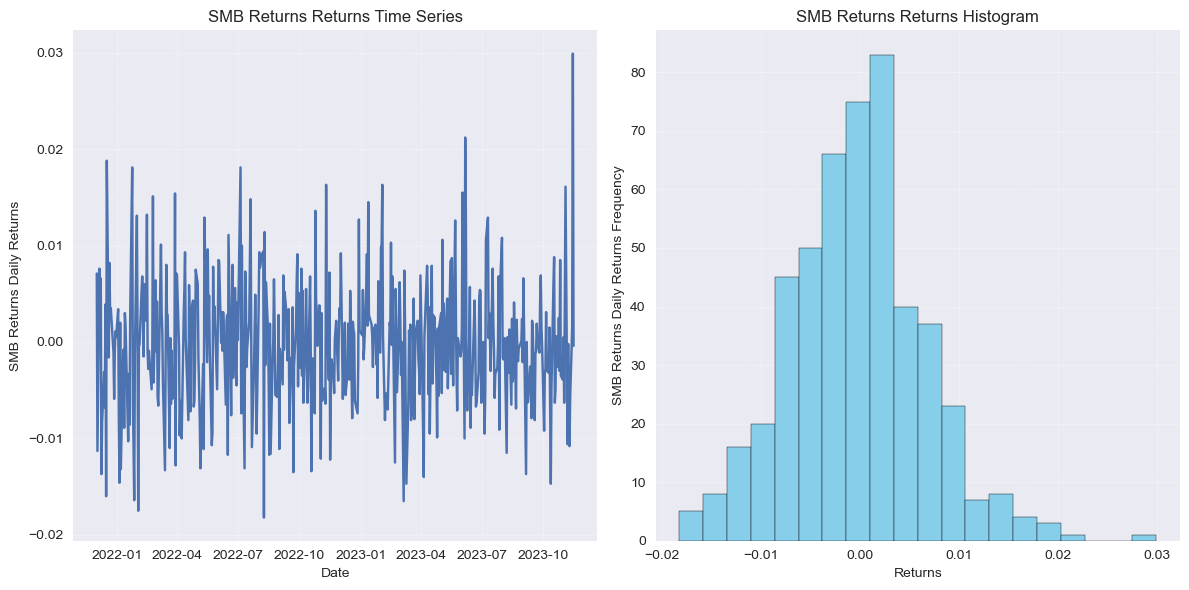

In [ ]:
display(Markdown(f"### **Fama-French 3 Factors: Small Minus Big Returns** \n ***"))
display(Markdown(f"""
    From the distribution of SMB returns below,  we can see that the SMB returns during this period were close to normally distributed with a slight positive skew.
    Although, there seems to be high density of data points around slightly negative returns.
"""))
PlotDynamics.plot_returns_ts_hist(
    ff3_df['SMB'], "SMB Returns"
)

### **Fama-French 3 Factors: High Minus Low Returns** 
 ***


    From the distribution of HML returns below, we can easily see that the returns over this period for the HML factor was approximately normally distributed,
    with slight negative skew.


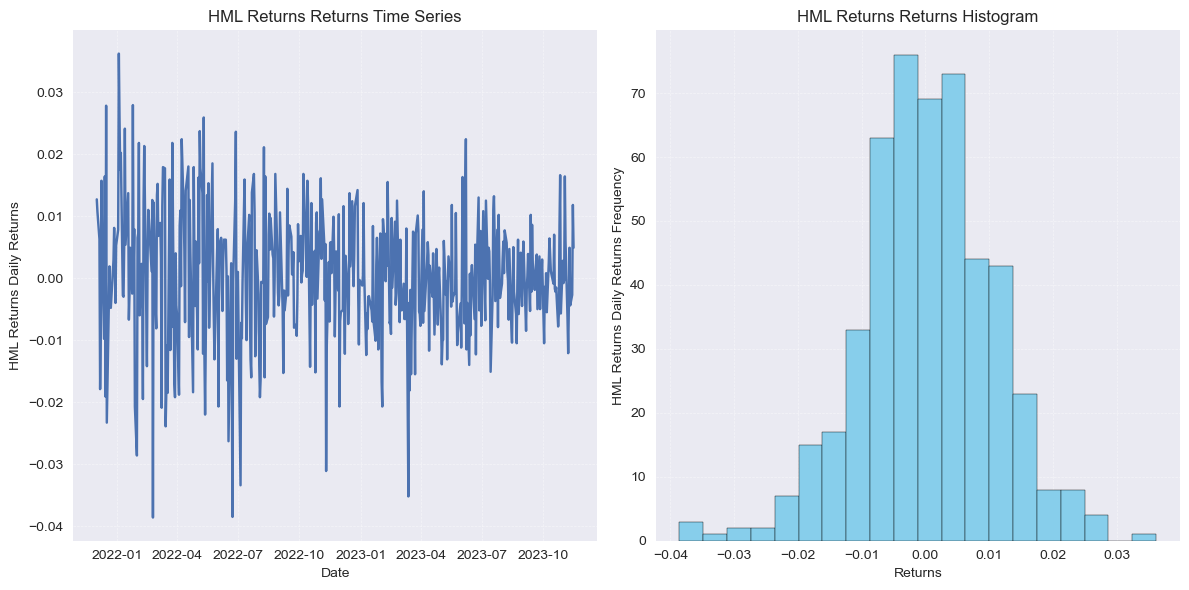

In [ ]:
display(Markdown(f"### **Fama-French 3 Factors: High Minus Low Returns** \n ***"))
display(Markdown(f"""
    From the distribution of HML returns below, we can easily see that the returns over this period for the HML factor was approximately normally distributed,
    with slight negative skew.
"""))
PlotDynamics.plot_returns_ts_hist(
    ff3_df['HML'], "HML Returns"
)

In [ ]:
model = sm.OLS(trading_strategy_performance_df['strategy_portfolio_returns'], sm.add_constant(ff3_df[['Mkt-RF', 'SMB', 'HML']]))
results = model.fit()

display(Markdown(f"### **Fama-French 3 Factors: Decomposition of Trading Strategy** \n ***"))
display(Markdown(f"""
    From the regression results below, it is apparent that none of the factors display statistical significance. The intercept (alpha) lacks statistical significance, 
    implying that the strategy's performance, whether positive or negative, cannot be consistently attributed to factors beyond those already considered. Furthermore, 
    both the market factor (Mkt-RF) and the size factor (SMB) yield non-significant results. While Mkt-RF has a slightly positive coefficient, SMB shows a negative 
    coefficient. Similarly, the value factor (HML) presents a negative coefficient but fails to achieve statistical significance.

    In summary, the Fama-French Three-Factor Model, when subjected to an F-test, does not exhibit statistical significance. As a result, we conclude that the 
    Fama-French Three-Factor Model may not serve as an appropriate framework for decomposing the returns generated by our strategy.
"""))
display(results.summary())

### **Fama-French 3 Factors: Decomposition of Trading Strategy** 
 ***


    From the regression results below, it is apparent that none of the factors display statistical significance. The intercept (alpha) lacks statistical significance, 
    implying that the strategy's performance, whether positive or negative, cannot be consistently attributed to factors beyond those already considered. Furthermore, 
    both the market factor (Mkt-RF) and the size factor (SMB) yield non-significant results. While Mkt-RF has a slightly positive coefficient, SMB shows a negative 
    coefficient. Similarly, the value factor (HML) presents a negative coefficient but fails to achieve statistical significance.

    In summary, the Fama-French Three-Factor Model, when subjected to an F-test, does not exhibit statistical significance. As a result, we conclude that the 
    Fama-French Three-Factor Model may not serve as an appropriate framework for decomposing the returns generated by our strategy.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     strategy_portfolio_returns   R-squared:                       0.001
Model:                                    OLS   Adj. R-squared:                 -0.005
Method:                         Least Squares   F-statistic:                    0.2005
Date:                        Thu, 25 Jan 2024   Prob (F-statistic):              0.896
Time:                                22:32:01   Log-Likelihood:                 1977.2
No. Observations:                         492   AIC:                            -3946.
Df Residuals:                             488   BIC:                            -3930.
Df Model:                                   3                                         
Covariance Type:                    nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.103      0.270      -0.000       0.001
Mkt-RF        -0.0081      0.017     -0.471      0.638      -0.042       0.026
SMB           -0.0155      0.032     -0.481      0.630      -0.079       0.048
HML           -0.0071      0.022     -0.328      0.743      -0.049       0.035
==============================================================================
Omnibus:                      417.212   Durbin-Watson:                   2.220
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            74510.736
Skew:                          -2.825   Prob(JB):                         0.00
Kurtosis:                      63.023   Cond. No.                         168.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### **Correlation: Trading Strategy and Fama-French 3 Factors** 
 ***


    This is one of my favorite charts for displaying correlations. It gives a great visual of all the data points from both axes and the density of the data points.
    In the chart below, we can see that our trading strategy has low correlation with the Fama-French 3 factor models even when it is actively trading. The spread 
    seems to have relatively low correlation with the 3 factors. Further more, our trading strategy has many periods where it is stopped out, or has no attractive 
    trades, thus sits at zero returns and reducing corelation even more.


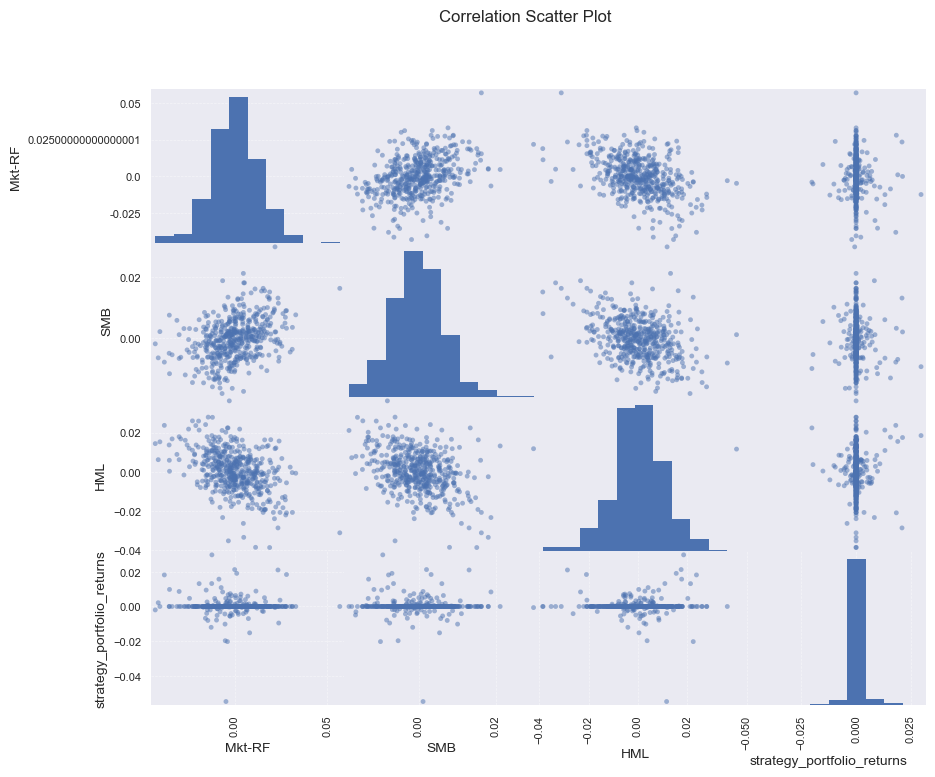

In [ ]:
display(Markdown(f"### **Correlation: Trading Strategy and Fama-French 3 Factors** \n ***"))
display(Markdown(f"""
    This is one of my favorite charts for displaying correlations. It gives a great visual of all the data points from both axes and the density of the data points.
    In the chart below, we can see that our trading strategy has low correlation with the Fama-French 3 factor models even when it is actively trading. The spread 
    seems to have relatively low correlation with the 3 factors. Further more, our trading strategy has many periods where it is stopped out, or has no attractive 
    trades, thus sits at zero returns and reducing corelation even more.
"""))
scatter_matrix(pd.concat([ff3_df[['Mkt-RF', 'SMB', 'HML']], trading_strategy_performance_df['strategy_portfolio_returns']], axis=1), figsize=(10, 8), diagonal='hist')

plt.suptitle("Correlation Scatter Plot")
plt.show()

### 3. Fama-French Decomposition Conclusion

***
**Factor Returns:**

The analysis of the three charts above reveals that all three factor returns from the Fama-French model exhibit relatively normal distribution patterns. Specifically, SMB displays a slight right skew, indicating a slightly heavier tail on the right side of the distribution. On the other hand, HML demonstrates a small left skew, suggesting a subtle tail on the left side. Mkt-RF, in contrast, appears mostly symmetric and exhibits the most normal distribution among the three factors.

***
**Strategy Decomposition:**

Upon examining the regression results, it is evident that none of the factors exhibit statistical significance. The intercept (alpha) fails to reach statistical significance, indicating that there is no consistent outperformance or underperformance that can be attributed to the strategy beyond what is explained by the selected factors. Moreover, both the market factor (Mkt-RF) and the size factor (SMB) show non-significant results, with Mkt-RF having a slightly positive coefficient and SMB displaying a negative coefficient. Similarly, the value factor (HML) exhibits a negative coefficient but lacks statistical significance.

In summary, the comprehensive Fama-French Three-Factor Model, when subjected to the F-test, fails to demonstrate statistical significance. Consequently, we conclude that the Fama-French Three-Factor Model may not be a suitable framework for decomposing the returns generated by our strategy.

***
**Strategy Correlation:**

We can see from the correlation scatter plot that the correlation between our trading strategy returns and the Fama-French 3 Factors are very low. This may be a good sign for our trading strategy since, we do not want to generate returns from taking on certain factor risks.

### 4. Trading Strategy Performance in High/Low Volatility
***

**Analysis:**

Our goal here is to see how our strategy performs during periods of high volatility and low volatility which will be benchmarked using the prices of the SVOL ETF.

**Procedure:**

We'll start off by looking at the SVOL ETF over our time horizon and then dive deeper into the correlation metrics and other statistics.

### **SVOL Price Dynamics** 
 ***


    We can see that the SVOL trading volume had signficantly increased towards the end of 2023. Combined with the next chart, it is interesting to see that larger
    volumnes of SVOL are being traded during times of low volatility in the SVOL ETF.


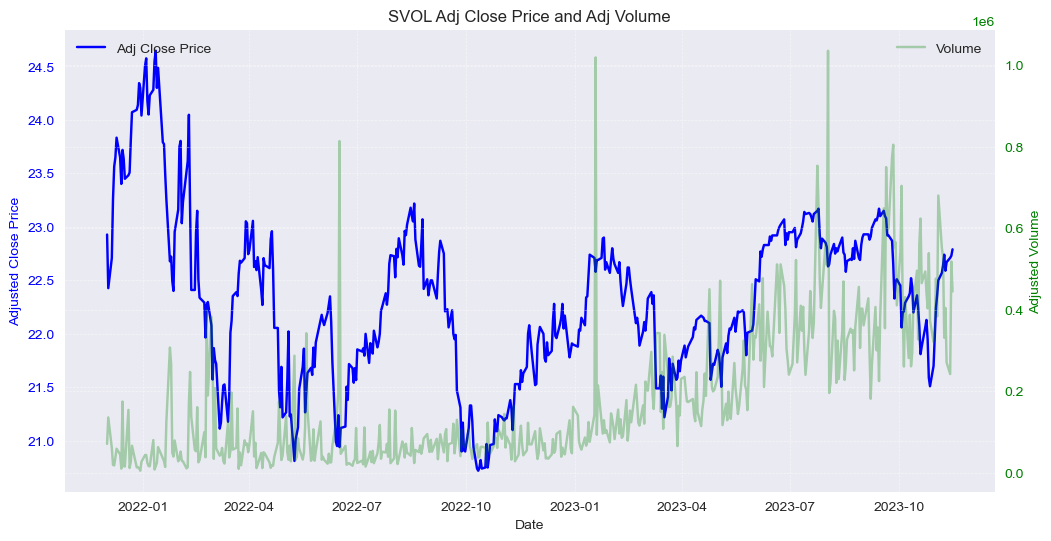

In [ ]:
display(Markdown(f"### **SVOL Price Dynamics** \n ***"))
display(Markdown(f"""
    We can see that the SVOL trading volume had signficantly increased towards the end of 2023. Combined with the next chart, it is interesting to see that larger
    volumnes of SVOL are being traded during times of low volatility in the SVOL ETF.
"""))
PlotDynamics.plot_price_volume(svol_df, 'SVOL')

### **SVOL Returns Dyanmics** 
 ***


    In the charts below, we can see that the distribution of SVOL returns are negatively skewed but with the mean shifted towards right. Also note that the volatility
    of SVOL also increases significantly during the year of 2022.


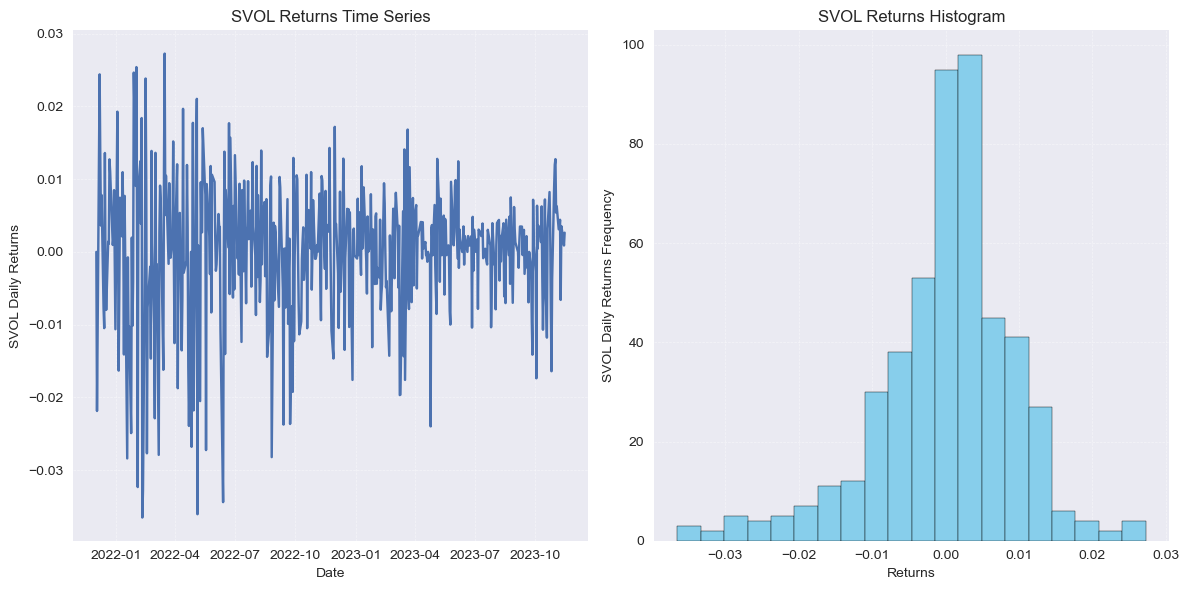

In [ ]:
display(Markdown(f"### **SVOL Returns Dyanmics** \n ***"))
display(Markdown(f"""
    In the charts below, we can see that the distribution of SVOL returns are negatively skewed but with the mean shifted towards right. Also note that the volatility
    of SVOL also increases significantly during the year of 2022.
"""))
svol_df['returns'] = svol_df['adj_close'].pct_change().fillna(0)
PlotDynamics.plot_returns_ts_hist(
    svol_df['returns'],
    "SVOL",
)

### **SVOL, GDS, and RING Volume Dyanmics** 
 ***


    We can clearly see that GDS has much more trading volume. With the current setup of the trading strategy we may need to watch out for
    the RING trading more than SVOL if we plan to use SVOL as a hedge against our trading strategy.


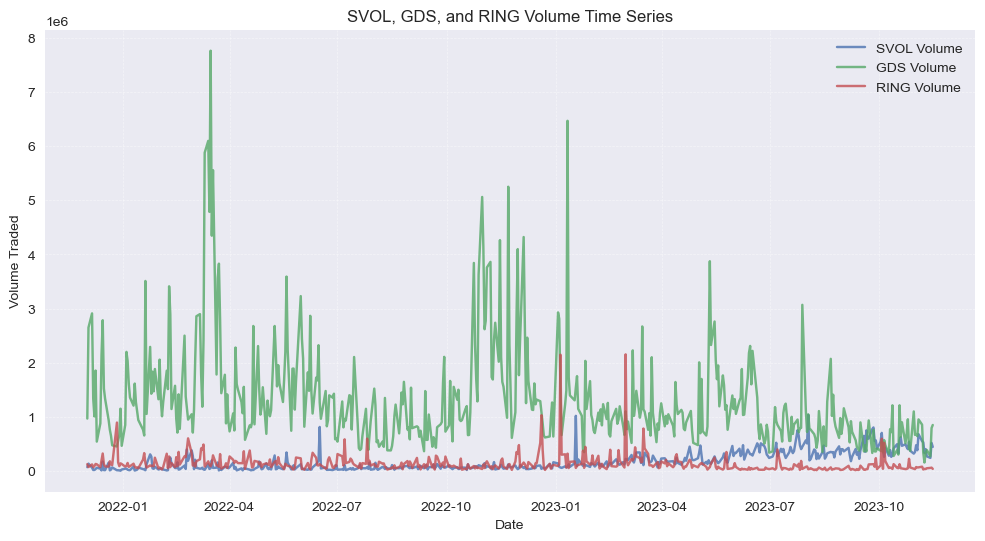

In [ ]:
display(Markdown(f"### **SVOL, {SpreadTicker.ticker1}, and {SpreadTicker.ticker2} Volume Dyanmics** \n ***"))
display(Markdown(f"""
    We can clearly see that {higher_volume_ticker} has much more trading volume. With the current setup of the trading strategy we may need to watch out for
    the {lower_volume_ticker} trading more than SVOL if we plan to use SVOL as a hedge against our trading strategy.
"""))
PlotDynamics.plot_multiple_ts(
    [
        svol_df['adj_volume'],
        ticker1_df['adj_volume'],
        ticker2_df['adj_volume']
    ],
    [
        f"SVOL Volume",
        f"{SpreadTicker.ticker1} Volume",
        f"{SpreadTicker.ticker2} Volume",
    ],
    xlabel="Date",
    ylabel=f"Volume Traded",
    title=f"SVOL, {SpreadTicker.ticker1}, and {SpreadTicker.ticker2} Volume Time Series",
    alphas=[0.8,0.8,0.8]
)

### **SVOL Correlation with Trading Strategy** 
 ***


    Below is a chart of the correlation between SVOL and our trading strategy. It seems like our trading strategy has relatively low correlation with SVOL since we
    are focused on the gold mining industry. It is expected that a bit of volatility spike in the SP500 does not have too much of an impact on gold miners as much
    as tech or retail.


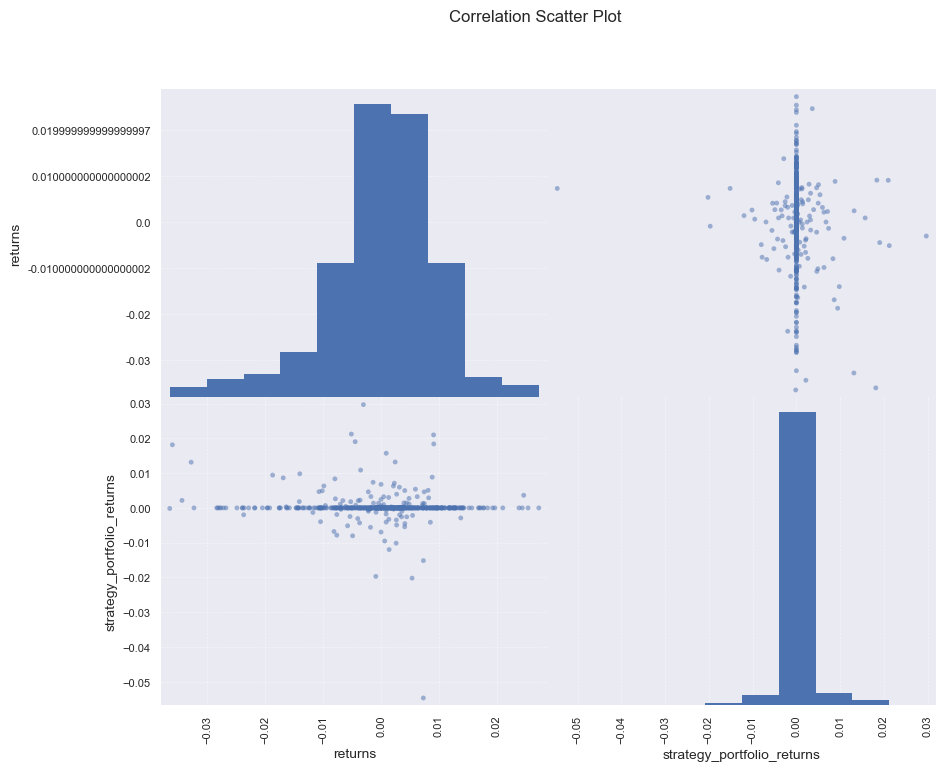

In [ ]:
display(Markdown(f"### **SVOL Correlation with Trading Strategy** \n ***"))
display(Markdown(f"""
    Below is a chart of the correlation between SVOL and our trading strategy. It seems like our trading strategy has relatively low correlation with SVOL since we
    are focused on the gold mining industry. It is expected that a bit of volatility spike in the SP500 does not have too much of an impact on gold miners as much
    as tech or retail.
"""))
scatter_matrix(pd.concat([svol_df['returns'], trading_strategy_performance_df['strategy_portfolio_returns']], axis=1), figsize=(10, 8), diagonal='hist')
plt.suptitle("Correlation Scatter Plot")
plt.show()

## VI. Research Conclusion

### 1. Conclusion Report

This analysis commenced with data extraction from Quandl and Ken French's website, followed by thorough data cleaning tailored for our research objectives. The subsequent exploration focused on understanding the behavior of each component within the spread, shedding light on the dynamics of the two ETFs over the specified time frame.

The implementation phase involved the execution of our trading strategy based on signals derived from the spread of returns between the two ETFs. Attempts were made to decompose the returns using the Fama-French Three-Factor Model, and a correlation analysis was performed between SVOL and our trading strategy. Notably, the Fama-French Three-Factor Model exhibited insignificance in explaining or decomposing the returns of our trading strategy. Moreover, our trading strategy demonstrated a low correlation with SVOL. Given that our selected ETF pair focused on the gold mining industry, the limited fundamental reasons for correlation with market volatility underscored the importance of systematic risk.

In summary, this analysis culminated in the development of a profitable trading strategy centered around the spread between the returns of two gold miner ETFs.